# Car price prediction
**Project Description:** Prediction of car prices by car's characteristics. There is no training sample with correct answers. It must be found from external sources.

**Goal:** To identify cars whose price is below market.

**Objectives:** Create model to predict car prices.

**Dataset Description:** Dataset consists of 0 rows into train set and 3 637 rows into test set.

Dataset features:

1. bodyType;
2. brand;
3. color;
4. fuelType;
5. modelDate;
6. name - model name;
7. numberOfDoors;
8. productionDate;
9. vehicleConfiguration;
10. vehicleTransmission;
11. engineDisplacement;
12. enginePower;
13. description;
14. mileage;
15. Комплектация;
16. Привод;
17. Руль - left or right;
18. Состояние - needed for repair or not;
19. Владельцы - ;
20. ПТС - ;
21. Таможня - ;
22. Владение - .

# Work plan
1. Collect data from external sources.
2. Base (default) processing of features making the baseline.
3. Whole optimization of initial features (without feature engineering) with baseline settings.
4. Feature engineering + polynomial features + dummies.
5. Find optimum sample value to define usefull features.
6. Find usefull features.
7. Optimize hyperparameters for each model in the stack.
8. Optimize hyperparameters for meta model of the stack.

In [1]:
import os
import re
import ast
import math
import json
import statistics
from collections import Counter, defaultdict
from itertools import chain, combinations
from pprint import pprint

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from bs4 import BeautifulSoup
from scipy.stats import ttest_ind
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix, auc, roc_auc_score, roc_curve, SCORERS
from sklearn.utils.class_weight import compute_class_weight

pd.options.display.max_columns = 40

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/car-data-moskva/car_data_novosibirsk.csv
/kaggle/input/car-data-moskva/car_refs_moskva.csv
/kaggle/input/car-data-moskva/car_data_moskva.csv
/kaggle/input/car-data-moskva/car_refs_novosibirsk.csv
/kaggle/input/sf-dst-car-price/test.csv
/kaggle/input/sf-dst-car-price/sample_submission.csv
/kaggle/working/__notebook__.ipynb


In [3]:
# Save requirements
!pip freeze > requirements.txt

In [4]:
# G L O B A L   C O N S T A N T S
# Random seed
RANDOM_SEED = 42
# Suffix for features with power of -1
MINUS_ONE_SUFFIX = '_1'
# Suffix for duplicated features in various feature category
DUPLICATE_SUFFIX = '_dup'
# Target feature
TARGET = 'price'
# ID feature
IDENT = 'id'
# Binary feature to separate train and test data
TRAIN = 'TRAIN'
# Target metric
METRIC = 'MAPE'
# Data, kernel and working paths
PATH_DATA = '/kaggle/input/sf-dst-car-price/'
PATH_KERNEL = '/kaggle/input/kernel341ca18171/'
PATH_WORKING = '/kaggle/working/'
# Flag of availability to drop rows
DROP_AVAL = False

# Data preparing
## Collecting and formating

In [5]:
def get_cars_refs(url_cars_list, max_pages_num):
    """Get list of car data URLs from URL of car table
    
    max_pages_num - maximum number of pages to request from table.
    If there is no some page number, it will pass to the next page number.
    """
    # Cycle over pages
    car_refs = []
    for page in range(1, max_pages_num + 1):
        # Do URL request
        response = requests.get(url_cars_list+str(page))
        
        # If response is normal
        if response.status_code == 200:
            # Print page number
            print(f'Page {page}')
            
            # Parse page and find requred references
            for car in BeautifulSoup(response.content, 'html.parser').find_all(
                class_="Link ListingItemTitle-module__link"
            ):
                # Add reference to list
                car_refs.append(car['href'])
    
    # Save result to file
    car_refs = pd.DataFrame(car_refs)
    car_refs.drop_duplicates(inplace=True, ignore_index=True)
    car_refs.to_csv('car_refs.csv', index=False)
    
    return car_refs


def get_cars_data(refs, max_pages_range=None):
    """Get cars' data from cars' URL"""
    # Create dataframe
    data = {
        'reference': [], 'bodyType': [], 'brand': [], 'color': [], 'fuelType': [],
        'modelDate': [], 'name': [], 'numberOfDoors': [], 'productionDate': [],
        'vehicleConfiguration': [], 'vehicleTransmission': [], 'engineDisplacement': [],
        'enginePower': [], 'description': [], 'mileage': [], 'Комплектация': [],
        'Привод': [], 'Руль': [], 'Состояние': [], 'Владельцы': [], 'ПТС': [],
        'Таможня': [], 'Владение': [], 'id': [], 'price': [],
    }
    
    # Cycle over references
    units_num = refs.index if max_pages_range == None \
        else range(37 * (max_pages_range[0]-1), 37 * max_pages_range[1])
    print(units_num)
    for i in units_num:
        print(i, end='')
        # Print page number and save data
        if not (i % 37):
            print(f'Page {i//37 + 1}')
            pd.DataFrame(data).to_csv('car_data.csv', index=False)
        
        # Do URL request
        response = requests.get(refs.iat[i, 0])
        
        # If response is normal
        if response.status_code == 200:
            # Parse 'price'
            parse = BeautifulSoup(response.content, 'html.parser').find(
                class_="OfferPriceCaption__price"
            )
            if parse is not None:
                price = re.findall('\d+', parse.contents[0].replace('\xa0', ''))
                price = float(price[0]) if len(price) > 0 else None
                data['price'].append(price)
            
                # Fill 'reference'
                data['reference'].append(refs.iat[i, 0])

                # Fill absences
                data['modelDate'].append(None)
                data['numberOfDoors'].append(None)
                data['vehicleConfiguration'].append(None)
                data['description'].append(None)
                data['id'].append(None)

                # Parse 'brand', 'name'
                parse = BeautifulSoup(response.content, 'html.parser').find_all(
                    class_="Link Link_color_gray CardBreadcrumbs__itemText"
                )
                data['brand'].append(parse[0].contents[0].replace('\xa0', ' ')
                    if len(parse) > 0 else None)
                data['name'].append(parse[4].contents[0].replace('\xa0', ' ')
                    if len(parse) > 4 else None)

                # Parse
                cell_data = {'mileage': None, 'vehicleTransmission': None, 'Привод': None,
                             'Руль': None, 'Состояние': None, 'Владельцы': None, 'ПТС': None,
                             'Таможня': None, 'productionDate': None, 'bodyType': None,
                             'color': None, 'engineDisplacement': None, 'enginePower': None,
                             'fuelType': None, 'Владение': None}
                next_cell = None
                CardInfo = BeautifulSoup(response.content, 'html.parser') \
                    .find('ul', class_="CardInfo")
                if CardInfo is not None:
                    for parse in CardInfo.find_all(class_="CardInfo__cell"):
                        if next_cell == 'productionDate':
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data[next_cell] = float(parse_.contents[0])
                        elif next_cell == 'mileage':
                            mileage = re.findall('\d+', parse.contents[0].replace('\xa0', ''))
                            mileage = float(mileage[0]) if len(mileage) > 0 else None
                            cell_data[next_cell] = mileage
                        elif next_cell == 'bodyType':
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data[next_cell] = parse_.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'color':
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data[next_cell] = parse_.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'engine':
                            parse_ = parse.find('div')
                            if parse_ is not None:
                                number_list = re.findall(
                                    '(\d\.?\d*) (л[\.с]*)', parse_.contents[0].replace('\xa0', ' ')
                                )
                                for number in number_list:
                                    if number[1] == 'л':
                                        cell_data['engineDisplacement'] = number[0] + ' LTR'
                                        break
                                for number in number_list:
                                    if number[1] == 'л.с.':
                                        cell_data['enginePower'] = number[0] + ' N12'
                                        break
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data['fuelType'] = parse_.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'vehicleTransmission':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Привод':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Руль':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Состояние':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Владельцы':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'ПТС':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Таможня':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Владение':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')

                        next_cell = None

                        if parse.contents[0] == 'год выпуска':
                            next_cell = 'productionDate'
                        elif parse.contents[0] == 'Пробег':
                            next_cell = 'mileage'
                        elif parse.contents[0] == 'Кузов':
                            next_cell = 'bodyType'
                        elif parse.contents[0] == 'Цвет':
                            next_cell = 'color'
                        elif parse.contents[0] == 'Двигатель':
                            next_cell = 'engine'
                        elif parse.contents[0] == 'Коробка':
                            next_cell = 'vehicleTransmission'
                        elif parse.contents[0] == 'Привод':
                            next_cell = 'Привод'
                        elif parse.contents[0] == 'Руль':
                            next_cell = 'Руль'
                        elif parse.contents[0] == 'Состояние':
                            next_cell = 'Состояние'
                        elif parse.contents[0] == 'Владельцы':
                            next_cell = 'Владельцы'
                        elif parse.contents[0] == 'ПТС':
                            next_cell = 'ПТС'
                        elif parse.contents[0] == 'Таможня':
                            next_cell = 'Таможня'
                        elif parse.contents[0] == 'Владение':
                            next_cell = 'Владение'

                for key, value in cell_data.items():
                    data[key].append(value)

                # Parse 'Комплектация'
                Complectation = []
                CardCompl = BeautifulSoup(response.content, 'html.parser') \
                    .find(class_="CardComplectation CardOfferBody__contentIsland")
                if CardCompl is not None:
                    for tag in CardCompl.find_all(class_="CardComplectation__itemName"):
                        Complectation.append({'name': tag.contents[0], 'values': []})
                    for i, tag in enumerate(CardCompl.find_all(class_="CardComplectation__itemContent")):
                        for tag_inner in tag.find_all(class_="CardComplectation__itemContentEl"):
                            Complectation[i]['values'].append(tag_inner.contents[0])
                    Complectation = [str(Complectation)]
                else:
                    Complectation = []
                data['Комплектация'].append(str(Complectation))
            
    # Save result to file
    data = pd.DataFrame(data)
    data.to_csv('car_data.csv', index=False)

    return data

In [6]:
def collect_data():
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = []
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_moskva.csv'))
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_novosibirsk.csv'))
    df_train = pd.concat(df_train, ignore_index=True)
    df_train.drop_duplicates(subset='reference', inplace=True, ignore_index=True)
    df_test = pd.read_csv(PATH_DATA+'test.csv')
    sample_submission = pd.read_csv(PATH_DATA+'sample_submission.csv')

    # Join train and test datasets
    df_train[TRAIN] = 1 # Train flag = 1
    df_train[IDENT] = df_train.index + 3837
    df_test[TRAIN] = 0 # Train flag = 0
    df_test[TARGET] = 0 # Fill target variable of the test dataset with zeros
    df_test['reference'] = ''
    df_join = df_test.append(df_train, ignore_index=True) # Join
    
    return (df_join, sample_submission)


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'name': '(?:^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?',
        'engineDisplacement': '\d\.\d|undefined LTR',
        'enginePower': '\d+ N12',
        'Владельцы': '\d\s(?:владел(?:ец|ьца)|или более)',
        'Владение': '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$',
    }

    # Check and print result
    for column, regex in cols_regex.items():
        a = df[column].str.match(regex).sum()
        b = df[column].count()
        print(f"'{column}' feature matches the regex format '{regex}' for {a} of {b} rows")


def format_features(df):
    """Format dataset"""
    df.loc[df[TRAIN] == 1, 'productionDate'] = df.loc[df[TRAIN] == 1, 'productionDate'] - 1
    
    df.loc[(df['bodyType'] == 'внедорожник 5 дв.') & (df[TRAIN] == 1), 'numberOfDoors'] = 5
    df.loc[(df['bodyType'] == 'кабриолет') & (df[TRAIN] == 1), 'numberOfDoors'] = 2
    df.loc[(df['bodyType'] == 'компактвэн') & (df[TRAIN] == 1), 'numberOfDoors'] = 5
    df.loc[(df['bodyType'] == 'купе') & (df[TRAIN] == 1), 'numberOfDoors'] = 2
    df.loc[(df['bodyType'] == 'лифтбек') & (df[TRAIN] == 1), 'numberOfDoors'] = 5
    df.loc[(df['bodyType'] == 'родстер') & (df[TRAIN] == 1), 'numberOfDoors'] = 2
    df.loc[(df['bodyType'] == 'седан') & (df[TRAIN] == 1), 'numberOfDoors'] = 4
    df.loc[(df['bodyType'] == 'седан 2 дв.') & (df[TRAIN] == 1), 'numberOfDoors'] = 2
    df.loc[(df['bodyType'] == 'универсал 5 дв.') & (df[TRAIN] == 1), 'numberOfDoors'] = 5
    df.loc[(df['bodyType'] == 'хэтчбек 3 дв.') & (df[TRAIN] == 1), 'numberOfDoors'] = 3
    df.loc[(df['bodyType'] == 'хэтчбек 5 дв.') & (df[TRAIN] == 1), 'numberOfDoors'] = 5
    
    df['fuelType'] = df['fuelType'].str.lower()
    df.loc[df['fuelType'] == 'бензин, газобаллонное оборудование', 'fuelType'] = 'бензин'
    df.loc[df['fuelType'] == 'электро', 'fuelType'] = 'гибрид'# ??????????????????
    
    df.loc[df['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '0.7 LTR'
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: np.nan if x is np.nan
        else float(re.findall('\d\.?\d*', x)[0]))
    
    df['enginePower'] = df['enginePower'].apply(lambda x: np.nan if x is np.nan
        else int(re.findall('\d+', x)[0]))
    
    df['Комплектация'] = df['Комплектация'].str.strip("[]").str.strip("'\"")
    df.loc[df[TRAIN] == 1, 'Комплектация'] = df.loc[df[TRAIN] == 1, 'Комплектация'] \
        .str.replace("'", '"')
    df.loc[df['Комплектация'] == '', 'Комплектация'] = '[]'
    df['Комплектация'] = pd.Series([str(set(chain.from_iterable([js['values']
        for js in json.loads(row)]))).replace("', '", '|')[2:-2] for row in df['Комплектация']])

    df['Владельцы'] = df['Владельцы'].apply(lambda x: np.nan if x is np.nan
        else int(re.findall('\d', x)[0]))
    
    regex = '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$'
    df['Владение_year'] = df['Владение'].apply(lambda x: np.nan if x is np.nan
        else re.findall(regex, x)[0][0])
    df['Владение_month'] = df['Владение'].apply(lambda x: np.nan if x is np.nan
        else re.findall(regex, x)[0][1])
    df.loc[df['Владение_year'] == '', 'Владение_year'] = 0
    df.loc[df['Владение_month'] == '', 'Владение_month'] = 0
    df['Владение_year'] = df['Владение_year'].astype('float64')
    df['Владение_month'] = df['Владение_month'].astype('float64')
    df['Владение'] = 12*df['Владение_year'] + df['Владение_month']
    
    regex = '(^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?'
    df['name'] = df['name'].str.extract(regex, expand=False)
    df.loc[df['name'].isna(), 'name'] = 'noName'
    df['xDrive'] = df['name'].str.contains('xDrive').astype('uint8')
    df['name'] = df['name'].str.replace('xDrive', '')
    df['name'] = df['name'].str.strip(' ')
    df['sDrive'] = df['name'].str.contains('sDrive').astype('uint8')
    df['name'] = df['name'].str.replace('sDrive', '')
    df['name'] = df['name'].str.strip(' ')
#     df.loc[df['name'] == 'Active Hybrid 7L', 'name'] = 'ActiveHybrid'
    df.loc[df['name'] == 'Competition Package', 'name'] = 'Competition'
    df['s_index'] = 0
    df['L_index'] = 0
    df['M_index'] = 0
    df.loc[df['name'].str.contains('\d'), 's_index'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('s').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'L_index'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('L').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'M_index'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('M').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'xDrive'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('x').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'name'] = df.loc[df['name'].str.contains('\d'), 'name'].str.replace('[idsxLM]', '')
    df.loc[df['name'] == 'CS', 'name'] = 'noName' # ??????????????????
    df.loc[df['name'] == 'N42 316', 'name'] = '316'

## Feature engineering

In [7]:
def create_new_features(df):
    """Create new features from existing"""
    # Create binary features for NaN's
    df['Владение_NaN'] = df['Владение'].isna().astype('uint8')
    
    # Create duplicate of categorical columns for either ordinal and/or quantity features
    df['Владельцы'+DUPLICATE_SUFFIX] = df['Владельцы']

    # Create -1 degree quantity features
    minus_one_degree_cols = {
        'productionDate': ('max', 1), 'enginePower': ('min', 1),
        'mileage': ('min', 1), 'Владение': ('min', 1),
        #'price': ('min', 1)
    }
    for column, param in minus_one_degree_cols.items():
        if param[0] == 'min':
            df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min()
                + abs(df[column].mean()) + param[1])
        elif param[0] == 'max':
            df[column+MINUS_ONE_SUFFIX] = 1 / (df[column].max() - df[column]
                + abs(df[column].mean()) + param[1])
        else:
            raise ValueError

## Deleting of useless features

In [8]:
def delete_useless_features(df):
    """Delete useless features and data (rows)"""
    df.drop(df.loc[df['Руль'] != 'Левый'].index, inplace=True)
    df.drop(df.loc[df['Состояние'] != 'Не требует ремонта'].index, inplace=True)
    df.drop(df.loc[df['Таможня'] != 'Растаможен'].index, inplace=True)
    df.drop(df.loc[df['brand'] != 'BMW'].index, inplace=True)
    df.drop(df.loc[df['name'] == '140'].index, inplace=True)
    df.drop(df.loc[df['name'] == '315'].index, inplace=True)
    df.drop(df.loc[df['name'] == '316 Ecotronc'].index, inplace=True)
    df.drop(df.loc[df['name'] == '40e'].index, inplace=True)
    df.drop(df.loc[df['name'] == '435'].index, inplace=True)
    df.drop(df.loc[df['name'] == '524'].index, inplace=True)
    df.drop(df.loc[df['name'] == '525 X'].index, inplace=True)
    df.drop(df.loc[df['name'] == '635'].index, inplace=True)
    df.drop(df.loc[df['name'] == 'S'].index, inplace=True)
    df.drop(df.loc[df['name'] == '733'].index, inplace=True)
    df.drop(df.loc[df['name'] == '216'].index, inplace=True)
    df.drop(df.loc[df['bodyType'] == 'купе-хардтоп'].index, inplace=True)
    df.drop(df.loc[df['fuelType'].isna()].index, inplace=True)
    df.drop(df.loc[df['Владельцы'].isna()].index, inplace=True)
    df.drop(df.loc[df['ПТС'].isna()].index, inplace=True)
    
    df.drop(['modelDate',
             'description',
             'vehicleConfiguration',
             'Владение_year',
             'Владение_month',
             'reference',
             'Руль',
             'Состояние',
             'Таможня',
             'brand',], axis=1, inplace=True)

## Dirty data (wrong values) handling

In [9]:
def dirty_handling(df):
    """Replace wrong values to NaN for features with finit set of posible values"""
    pass

## Parse data

In [10]:
# refs = []
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=1890&year_to=2005&page=', 99))
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=2006&year_to=2010&page=', 99))
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=2011&year_to=2015&page=', 99))
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=2016&year_to=2020&page=', 99))
# refs = pd.concat(refs, ignore_index=True)
# refs.drop_duplicates(inplace=True, ignore_index=True)
# refs.to_csv('car_refs_moskva.csv', index=False)
# refs

# refs = []
# refs.append(pd.read_csv('/kaggle/input/car-data-moskva/car_refs_moskva.csv'))
# refs.append(pd.read_csv('/kaggle/input/car-data-moskva/car_refs_moskva_all.csv'))
# refs = pd.concat(refs, ignore_index=True)
# refs.drop_duplicates(inplace=True, ignore_index=True)
# refs.to_csv('car_refs_moskva.csv', index=False)
# refs

# refs = get_cars_refs('https://auto.ru/novosibirsk/cars/bmw/used/?output_type=table&page=', 99)
# refs.to_csv('car_refs_novosibirsk.csv', index=False)
# data = get_cars_data(refs)
# data.to_csv('car_data_novosibirsk.csv', index=False)

refs = get_cars_refs('https://auto.ru/ekaterinburg/cars/bmw/used/?output_type=table&page=', 99)
refs.to_csv('car_refs_ekaterinburg.csv', index=False)
data = get_cars_data(refs)
data.to_csv('car_data_ekaterinburg.csv', index=False)

refs = get_cars_refs('https://auto.ru/sochi/cars/bmw/used/?output_type=table&page=', 99)
refs.to_csv('car_refs_sochi.csv', index=False)
data = get_cars_data(refs)
data.to_csv('car_data_sochi.csv', index=False)

refs = get_cars_refs('https://auto.ru/irkutsk/cars/bmw/used/?output_type=table&page=', 99)
refs.to_csv('car_refs_irkutsk.csv', index=False)
data = get_cars_data(refs)
data.to_csv('car_data_irkutsk.csv', index=False)

Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Page 10
Page 11
Page 12
Page 13
Page 14
Page 15
Page 16
Page 17
Page 18
Page 19
Page 20
Page 21
Page 22
Page 23
Page 24
Page 25
Page 26
Page 27
Page 28
Page 29
Page 30
Page 31
Page 32
Page 33
Page 34
Page 35
Page 36
Page 37
Page 38
Page 39
Page 40
Page 41
Page 42
Page 43
Page 44
Page 45
Page 46
Page 47
Page 48
Page 49
Page 50
Page 51
Page 52
Page 53
Page 54
Page 55
Page 56
Page 57
Page 58
Page 59
Page 60
Page 61
Page 62
Page 63
Page 64
Page 65
Page 66
Page 67
Page 68
Page 69
Page 70
Page 71
Page 72
Page 73
Page 74
Page 75
Page 76
Page 77
Page 78
Page 79
Page 80
Page 81
Page 82
Page 83
Page 84
Page 85
Page 86
Page 87
Page 88
Page 89
Page 90
Page 91
Page 92
Page 93
Page 94
Page 95
Page 96
Page 97
Page 98
Page 99
RangeIndex(start=0, stop=805, step=1)
0Page 1
12345678910111213141516171819202122232425262728293031323334353637Page 2
38394041424344454647484950515253545556575859606162636465666768697071727374Page 3
757677787980818283

## Receiving of general information

In [11]:
df, sample_submission = collect_data()
check_features_format(df)
format_features(df)
create_new_features(df)
delete_useless_features(df)
dirty_handling(df)

'name' feature matches the regex format '(?:^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?' for 10004 of 10004 rows
'engineDisplacement' feature matches the regex format '\d\.\d|undefined LTR' for 9999 of 9999 rows
'enginePower' feature matches the regex format '\d+ N12' for 9999 of 9999 rows
'Владельцы' feature matches the regex format '\d\s(?:владел(?:ец|ьца)|или более)' for 10002 of 10002 rows
'Владение' feature matches the regex format '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$' for 4065 of 4065 rows


**Show general information of datasets**

In [12]:
df.loc[df[TRAIN] == 1].head()

,bodyType,color,fuelType,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Комплектация,Привод,Владельцы,ПТС,Владение,id,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,Владение_NaN,Владельцы_dup,productionDate_1,enginePower_1,mileage_1,Владение_1
3837,седан,чёрный,дизель,730,4.0,2018.0,автоматическая,3.0,249.0,22000.0,Электрорегулировка передних сидений|Подушки бе...,полный,1.0,Оригинал,10.0,3837,1,5500000.0,0,0,0,1,0,0,1.0,0.000497,0.002240,0.000006,0.017880
3838,внедорожник 5 дв.,белый,дизель,30,5.0,2017.0,автоматическая,3.0,249.0,16000.0,Подушка безопасности для защиты коленей водите...,полный,1.0,Оригинал,27.0,3838,1,4250000.0,0,0,0,0,0,0,1.0,0.000497,0.002240,0.000006,0.013712
3839,внедорожник 5 дв.,белый,бензин,35,5.0,2009.0,автоматическая,3.0,306.0,111000.0,t,полный,1.0,Оригинал,NaN,3839,1,1330000.0,0,0,0,0,0,1,1.0,0.000495,0.001986,0.000004,NaN
3840,внедорожник 5 дв.,серый,дизель,30,5.0,2018.0,автоматическая,3.0,249.0,17146.0,Легкосплавные диски|Парктроник передний|Подушк...,полный,1.0,Оригинал,NaN,3840,1,4699000.0,0,0,0,0,0,1,1.0,0.000497,0.002240,0.000006,NaN
3841,внедорожник 5 дв.,чёрный,дизель,30,5.0,2019.0,автоматическая,3.0,249.0,3.0,Электрорегулировка передних сидений|Подушки бе...,полный,1.0,Оригинал,4.0,3841,1,6878000.0,0,0,0,0,0,0,1.0,0.000497,0.002240,0.000007,0.020029


In [13]:
df.loc[df[TRAIN] == 0].head()

,bodyType,color,fuelType,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Комплектация,Привод,Владельцы,ПТС,Владение,id,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,Владение_NaN,Владельцы_dup,productionDate_1,enginePower_1,mileage_1,Владение_1
0,седан,чёрный,дизель,520,4.0,2017.0,автоматическая,2.0,190.0,158836.0,Подушка безопасности для защиты коленей водите...,задний,1.0,Оригинал,NaN,0,0,0.0,0,0,0,0,0,1,1.0,0.000497,0.002580,0.000003,NaN
1,седан,белый,дизель,318,4.0,2019.0,автоматическая,2.0,150.0,10.0,Подушки безопасности боковые|Подушки безопасно...,задний,1.0,Оригинал,NaN,1,0,0.0,0,0,0,0,0,1,1.0,0.000497,0.002878,0.000007,NaN
2,седан,синий,бензин,550,4.0,2012.0,автоматическая,4.4,407.0,120000.0,Парктроник передний|Климат-контроль 1-зонный|П...,полный,2.0,Оригинал,86.0,2,0,0.0,0,0,0,0,0,0,2.0,0.000496,0.001654,0.000004,0.00758
3,внедорожник 5 дв.,белый,дизель,30,5.0,2015.0,автоматическая,3.0,249.0,111466.0,Климат-контроль 1-зонный|Подушки безопасности ...,полный,2.0,Оригинал,NaN,3,0,0.0,0,0,0,0,0,1,2.0,0.000496,0.002240,0.000004,NaN
4,внедорожник 5 дв.,синий,дизель,50,5.0,2019.0,автоматическая,3.0,381.0,11891.0,Парктроник передний|Электрорегулировка передни...,полный,1.0,Оригинал,NaN,4,0,0.0,0,0,0,0,1,1,1.0,0.000497,0.001729,0.000006,NaN


In [14]:
sample_submission.head()

,id,price
0,0,5299000.0
1,1,1580000.0
2,2,2000000.0
3,3,2199000.0
4,4,935000.0


In [15]:
df.loc[df[TRAIN] == 1].info()
print()
df.loc[df[TRAIN] == 0].info()
print()
df.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6132 entries, 3837 to 10003
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             6132 non-null   object 
 1   color                6132 non-null   object 
 2   fuelType             6132 non-null   object 
 3   name                 6132 non-null   object 
 4   numberOfDoors        6132 non-null   float64
 5   productionDate       6132 non-null   float64
 6   vehicleTransmission  6132 non-null   object 
 7   engineDisplacement   6132 non-null   float64
 8   enginePower          6132 non-null   float64
 9   mileage              6132 non-null   float64
 10  Комплектация         6132 non-null   object 
 11  Привод               6132 non-null   object 
 12  Владельцы            6132 non-null   float64
 13  ПТС                  6132 non-null   object 
 14  Владение             2298 non-null   float64
 15  id                   6132 non-null

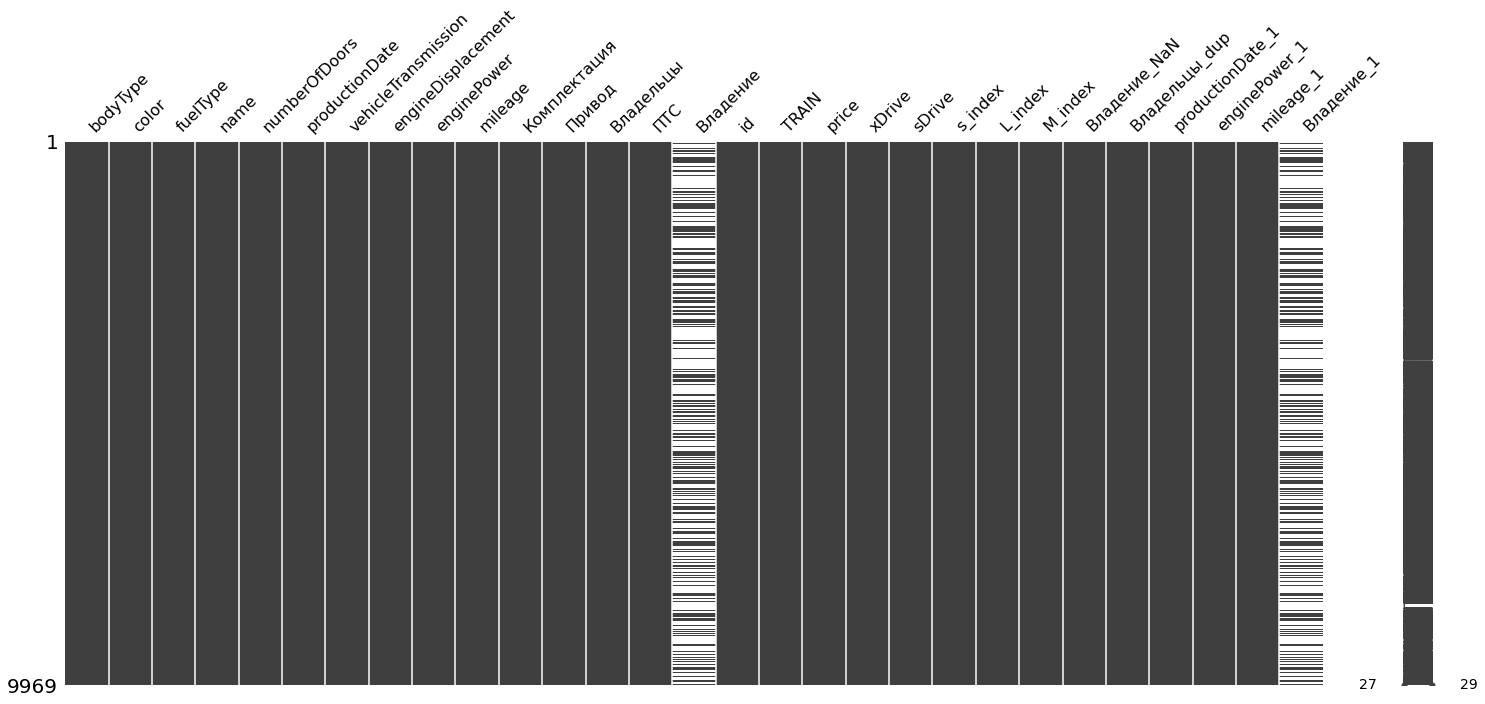

In [16]:
msno.matrix(df);

**Declare target variable, quantity, ordinal and categorical features**

In [17]:
# Declare categorical features
categ_bin_cols = [
    'ПТС',
    'xDrive',
    'sDrive',
    's_index',
    'L_index',
    'M_index',
    'Владение_NaN',
]
categ_many_cols = [
    'bodyType',
    'color',
    'fuelType',
    'name',
    'vehicleTransmission',
    'Привод',
    'Владельцы'+DUPLICATE_SUFFIX,
]
categ_multi_cols = [
    'Комплектация',
]

# Declare quantity features
quantity_cols = [
    'numberOfDoors',
    'productionDate',
    'engineDisplacement',
    'enginePower',
    'mileage',
    'Владельцы',
    'Владение',
    
    'productionDate'+MINUS_ONE_SUFFIX,
    'enginePower'+MINUS_ONE_SUFFIX,
    'mileage'+MINUS_ONE_SUFFIX,
    'Владение'+MINUS_ONE_SUFFIX,
]

# Declare categorized quantity features
quantity_categ_cols = [
]

# Declare ordinal features
ordinal_cols = [
]

# Update quantity, ordinal and categorical feature lists
categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
categ_many_cols = [col for col in categ_many_cols if col in df.columns]
categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
quantity_cols = [col for col in quantity_cols if col in df.columns]
quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
ordinal_cols = [col for col in ordinal_cols if col in df.columns]

**View unique values**

In [18]:
# Find and show number of unique values of categorical features
categorical_unique = {}
for column in categ_cols:
    # Handle categ_multi_cols features
    if column in categ_multi_cols:
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].str.split('|')))).sort_values(ascending=False)

    # Handle categ_bin_cols and categ_many_cols features
    else:
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].apply(lambda x: [x])))).sort_values(ascending=False)

    # Show result
    print((column + ':').ljust(21), end='')
    print(str(len(categorical_unique[column])).rjust(6))

ПТС:                      2
xDrive:                   2
sDrive:                   2
s_index:                  2
L_index:                  2
M_index:                  2
Владение_NaN:             2
bodyType:                11
color:                   15
fuelType:                 3
name:                    66
vehicleTransmission:      3
Привод:                   3
Владельцы_dup:            3
Комплектация:           177


In [19]:
# Show unique values of categorical features
pd.set_option('display.max_rows', None)

alphabet_order = False
for column in categ_cols:
    print(column + ':')
    if alphabet_order:
        print(categorical_unique[column].sort_index()) # in alphabet order
    else:
        print(categorical_unique[column]) # in frequency order
    print()
    
pd.reset_option('display.max_rows')

ПТС:
Оригинал    8638
Дубликат    1331
dtype: int64

xDrive:
0    9759
1     210
dtype: int64

sDrive:
0    9948
1      21
dtype: int64

s_index:
0    9811
1     158
dtype: int64

L_index:
0    9545
1     424
dtype: int64

M_index:
0    9823
1     146
dtype: int64

Владение_NaN:
1    5918
0    4051
dtype: int64

bodyType:
седан                4404
внедорожник 5 дв.    4041
купе                  502
хэтчбек 5 дв.         390
лифтбек               284
универсал 5 дв.       117
хэтчбек 3 дв.         109
кабриолет              70
родстер                37
седан 2 дв.             8
компактвэн              7
dtype: int64

color:
чёрный         3846
белый          1790
синий          1279
серый          1174
серебристый     586
коричневый      447
красный         313
зелёный         135
бежевый         108
голубой         104
золотистый       61
оранжевый        51
пурпурный        50
фиолетовый       20
жёлтый            5
dtype: int64

fuelType:
бензин    6811
дизель    3133
гибрид      25


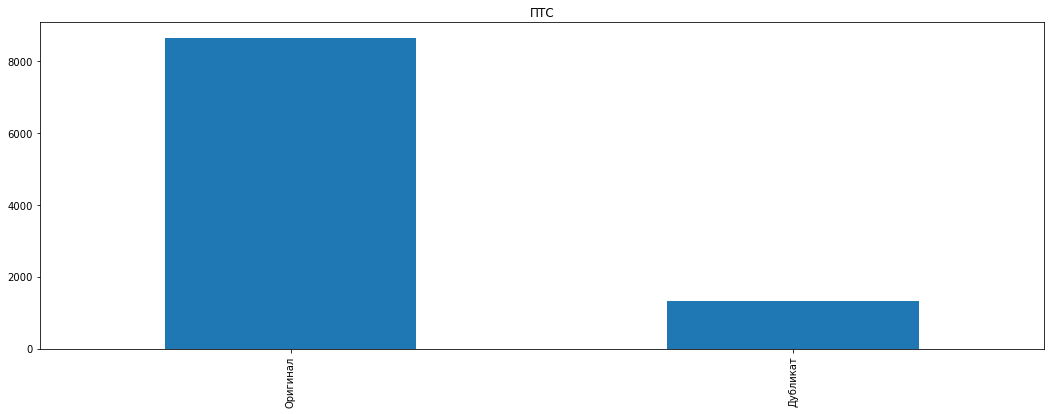

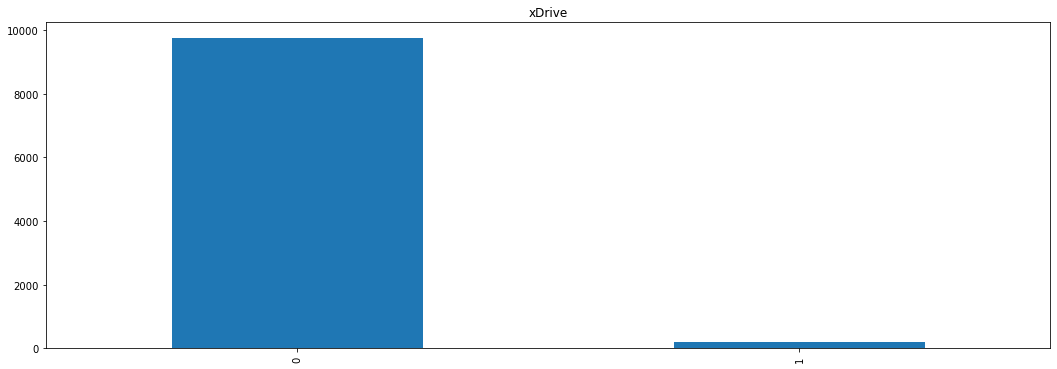

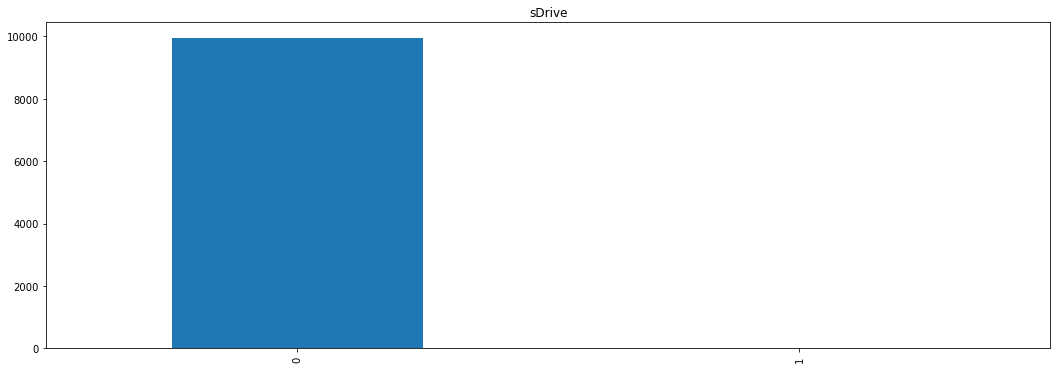

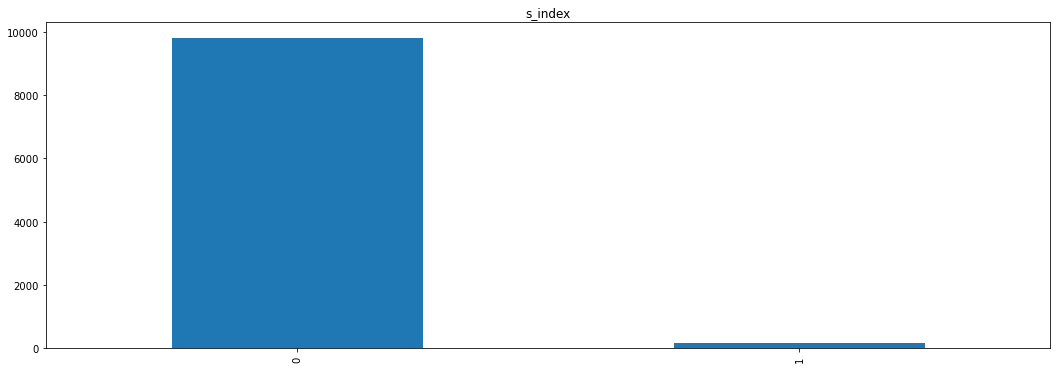

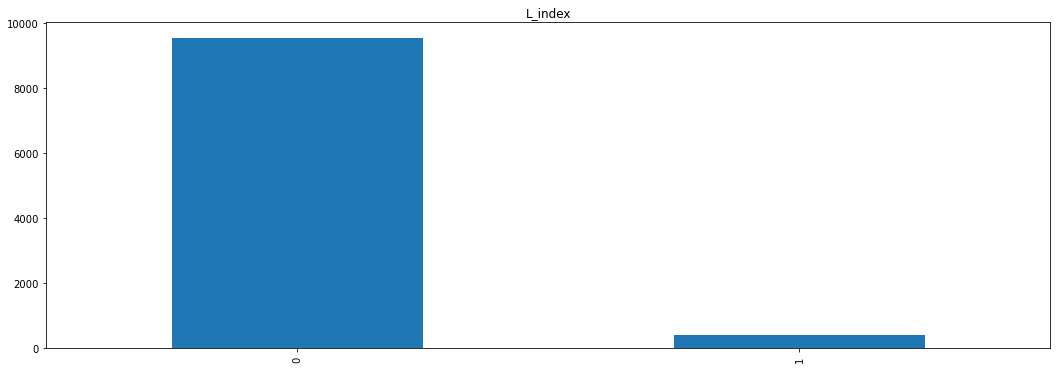

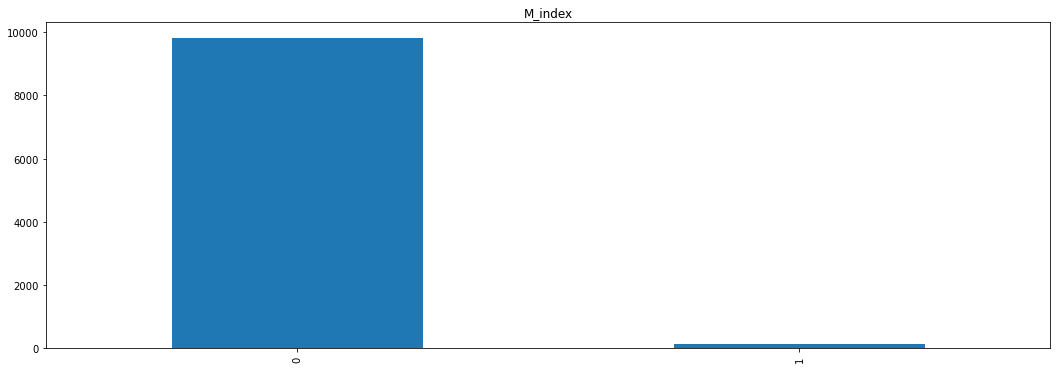

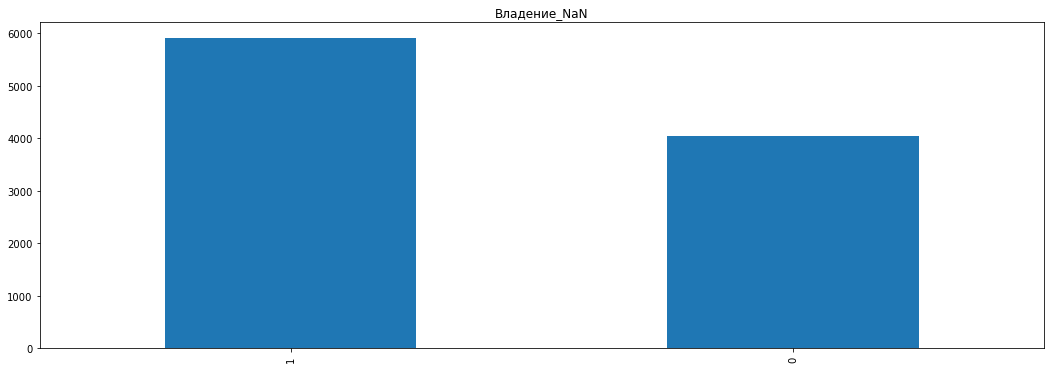

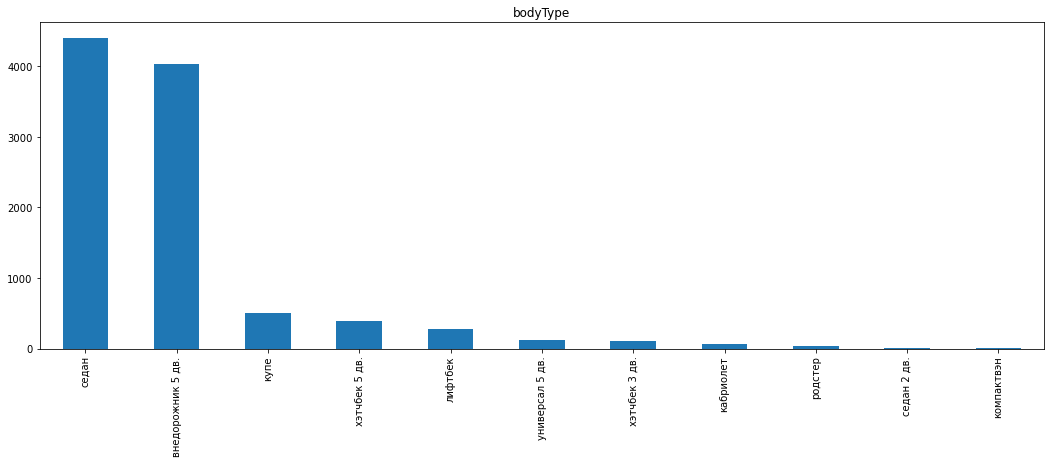

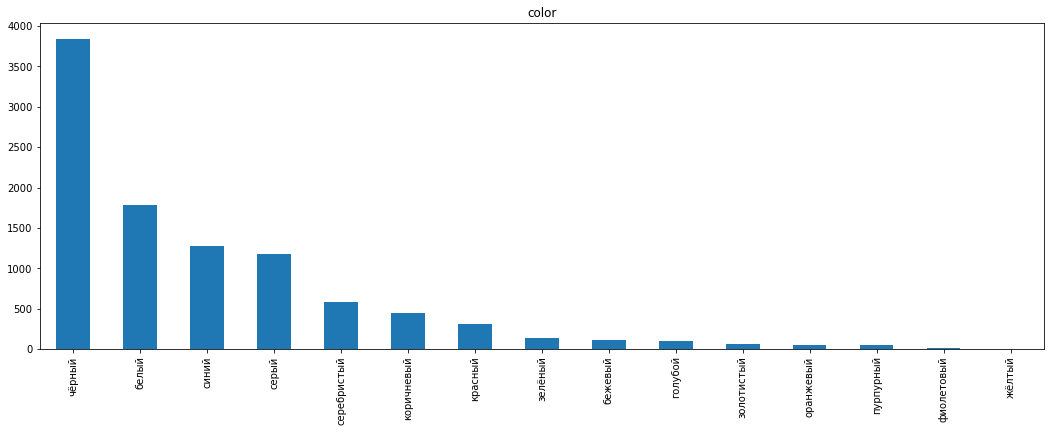

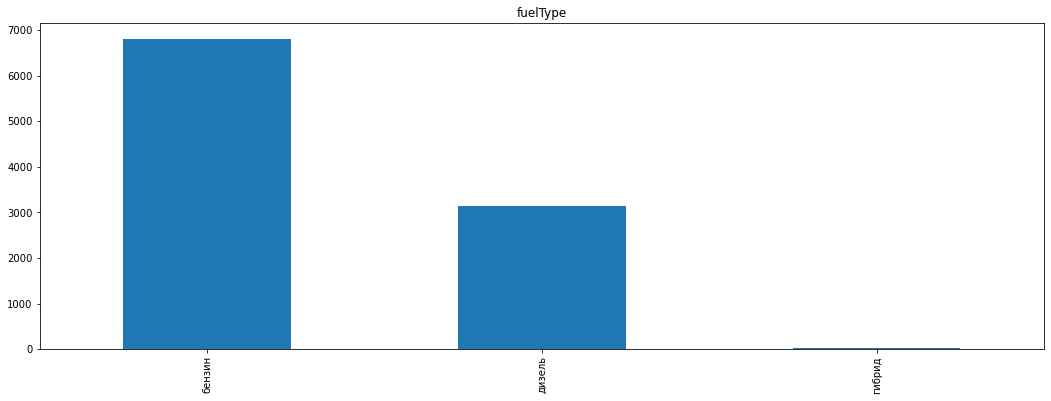

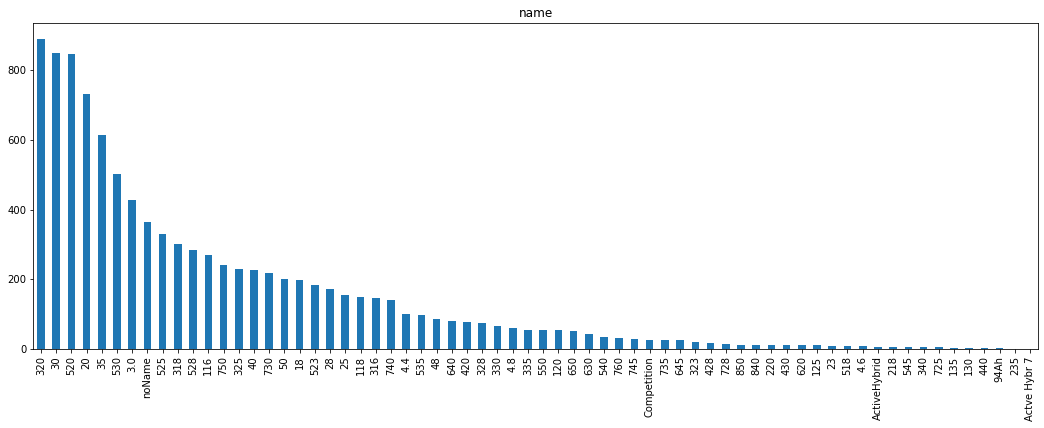

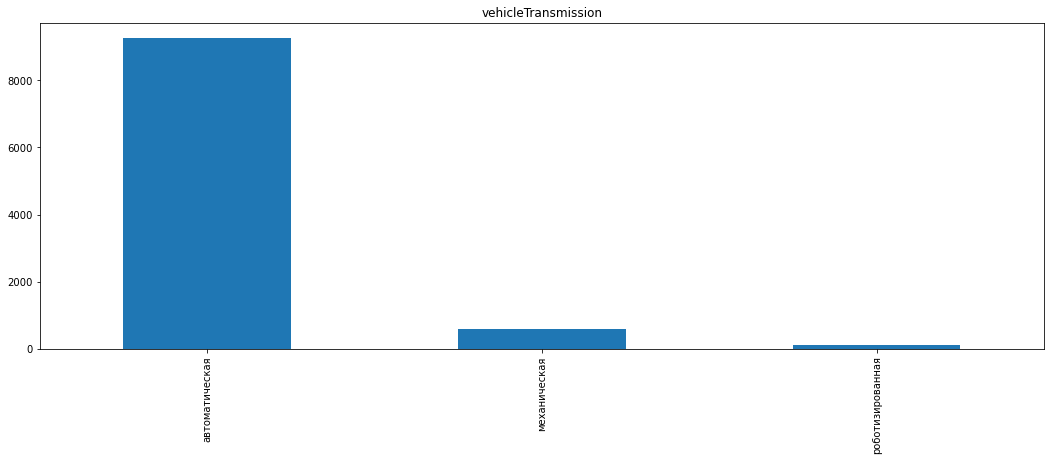

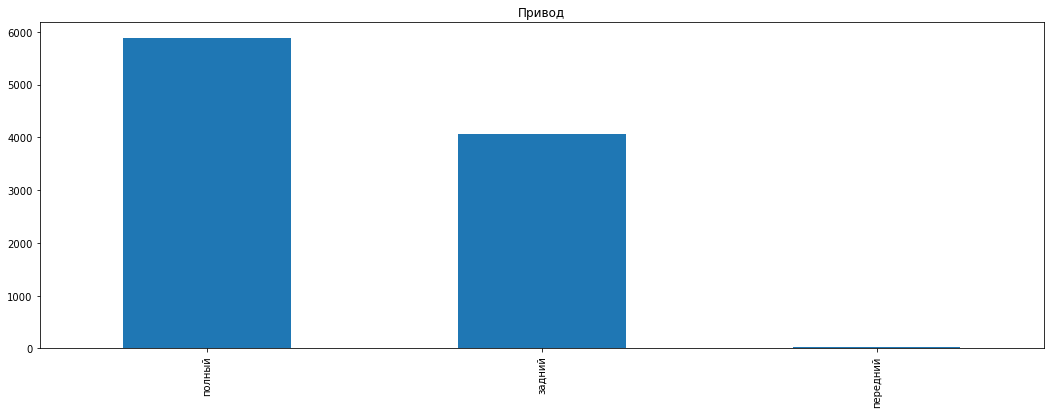

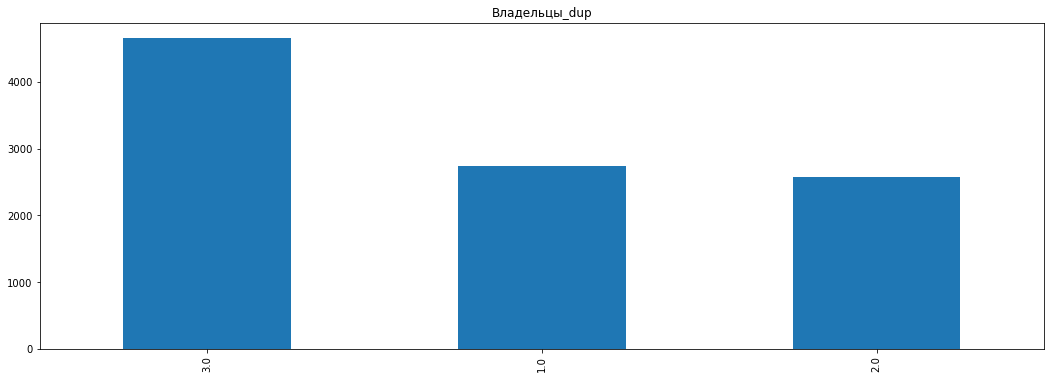

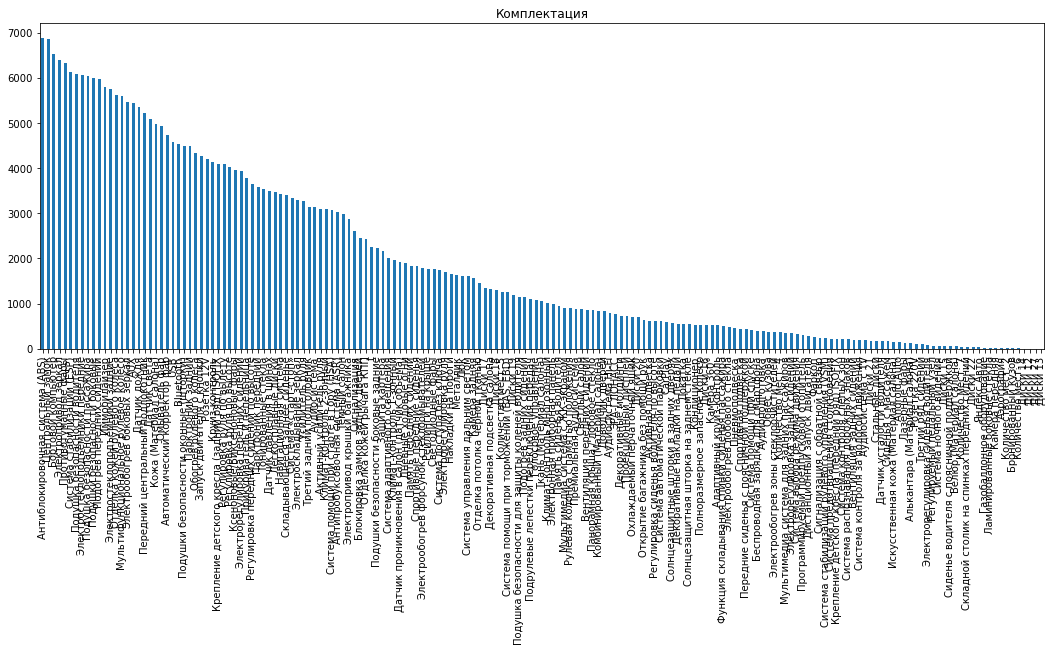

In [20]:
# Show distribution of categorical features
for column in categ_cols:
    categorical_unique[column].plot.bar(figsize=(18, 6), title=column)
    plt.show()

In [21]:
# Show number of unique values of quantity and ordinal features
for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    print(column.join(['', ':']).ljust(21), end='')
    print(str(df[column].nunique()).rjust(6))

numberOfDoors:            4
productionDate:          50
engineDisplacement:      27
enginePower:             88
mileage:               3735
Владельцы:                3
Владение:               195
productionDate_1:        50
enginePower_1:           88
mileage_1:             3735
Владение_1:             195


In [22]:
# Show unique values of quantity and ordinal features
columns = [ 'numberOfDoors',
            'productionDate',
            'engineDisplacement',
            'enginePower',
            'Владельцы',]

for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    if column in columns:
        print(column.join(['', ':']).ljust(21), end='')
        print(np.sort(df[column].unique()))

numberOfDoors:       [2. 3. 4. 5.]
productionDate:      [1936. 1937. 1947. 1948. 1949. 1952. 1968. 1971. 1974. 1977. 1979. 1981.
 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993.
 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017.
 2018. 2019.]
engineDisplacement:  [0.7 1.5 1.6 1.7 1.8 1.9 2.  2.2 2.5 2.8 2.9 3.  3.2 3.3 3.4 3.5 3.6 3.8
 4.  4.4 4.6 4.8 4.9 5.  5.4 6.  6.6]
enginePower:         [ 46.  51.  90.  98. 100. 101. 102. 105. 109. 113. 115. 116. 118. 122.
 125. 129. 136. 140. 143. 150. 156. 163. 170. 171. 177. 184. 188. 190.
 192. 193. 197. 204. 211. 218. 230. 231. 233. 234. 235. 238. 243. 245.
 249. 252. 258. 264. 265. 269. 272. 286. 300. 306. 313. 320. 321. 326.
 329. 333. 340. 343. 347. 355. 360. 367. 370. 374. 381. 387. 400. 407.
 410. 420. 431. 445. 449. 450. 460. 462. 507. 530. 544. 555. 560. 575.
 600. 609. 610. 625.]
Владельцы:           [1. 2. 3.]


## Visualization

In [23]:
def show_boxplots(df, show_target=False):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        

def show_histograms(df, show_target=False):
    """Show distributions of quantity and ordinal features"""
    # Fill the list of bins' step if know it
    bin_step = {
        'numberOfDoors': 1,
        'productionDate': 1,
        'Владельцы': 1,
    }
    
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = 20
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_CQF_boxplots(df):
    """Show boxplots of categorized quantity features"""
    NUM_OF_VALS = 10
    CATEGORY = 'feature_name'

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    categ_mask = {}
    top_categ_values = {}
    for i, column in enumerate(quantity_categ_cols):
        # Find masks
        categ_mask = {}
        top_categ_values = {}
        for column in quantity_categ_cols:
            # Find top NUM_OF_VALS values categorical feature
            top_categ_values[column] = categorical_unique[CATEGORY].index[:NUM_OF_VALS]

            # Find boolean masks
            categ_mask[column] = {}
            for value in top_categ_values[column]:
                categ_mask[column][value] = df[CATEGORY].str.contains(value)

        # Plot graphs
        if rows == 1:
            axs.boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_categ_values[column], rotation=5)
        else:
            axs[i].boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_categ_values[column], rotation=5)
            
    return (top_categ_values, categ_mask)
            
            
def show_CQF_histograms(df, top_categ_values, categ_mask):
    """Show distributions of categorized quantity features"""
    BINS = 100

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Plot graphs
        if rows == 1:
            for value in top_categ_values[column]:
                axs.hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs.set_title(column)
        else:
            for value in top_categ_values[column]:
                axs[i].hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs[i].set_title(column)

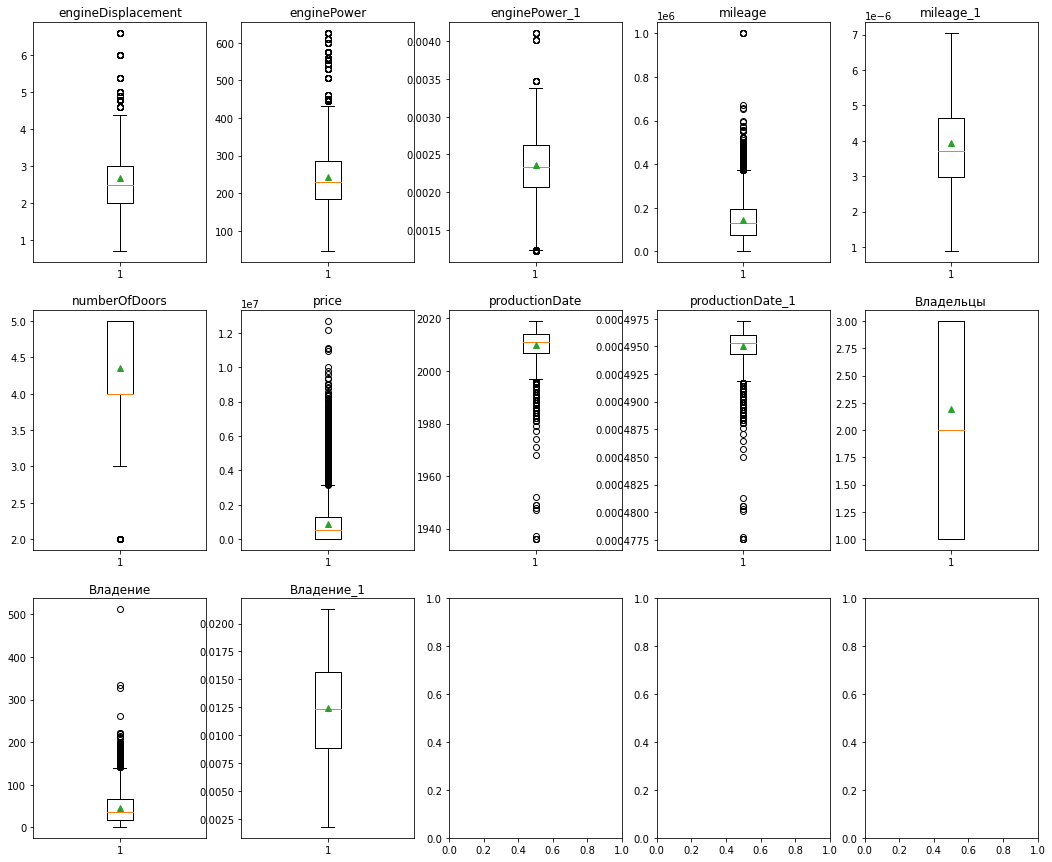

In [24]:
show_boxplots(df, show_target=True)

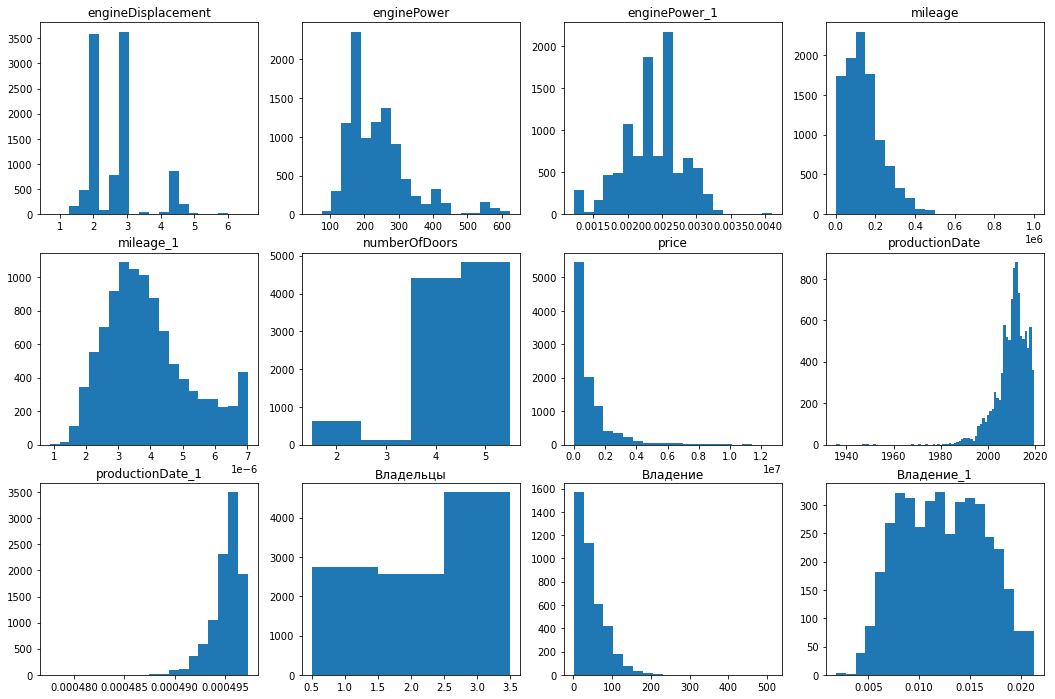

In [25]:
show_histograms(df, show_target=True)

In [26]:
# top_categ_values, categ_mask = show_CQF_boxplots(df)

In [27]:
# show_CQF_histograms(df, top_categ_values, categ_mask)

## Outliers handling

In [28]:
def delete_outliers(df, inplace=False):
    """Show number of outliers and delete rows with outliers"""
    # Define columns to show graphs
    columns = sorted(quantity_cols).copy()
    
    # Exclude some columns from the process
    cols = [

    ]
    for col in df.columns:
        if col in cols:
            columns.remove(col)
    
    idx_dict = {}
    for column in columns:
        # Calculate Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    if inplace:
        df.drop(idx, inplace=True)
        print(f"{str(len(idx)).rjust(6)} rows have been dropped")

In [29]:
# Show or delete outliers
print('train:')
delete_outliers(df.loc[df[TRAIN] == 1], inplace=DROP_AVAL)
print('test:')
delete_outliers(df.loc[df[TRAIN] == 0], inplace=DROP_AVAL)
print('join:')
delete_outliers(df, inplace=DROP_AVAL)

train:
   187 outliers are in column 'engineDisplacement'
   281 outliers are in column 'enginePower'
    32 outliers are in column 'enginePower_1'
   105 outliers are in column 'mileage'
   156 outliers are in column 'mileage_1'
   373 outliers are in column 'numberOfDoors'
   236 outliers are in column 'productionDate'
   236 outliers are in column 'productionDate_1'
    60 outliers are in column 'Владение'
test:
    86 outliers are in column 'engineDisplacement'
   280 outliers are in column 'enginePower'
   121 outliers are in column 'enginePower_1'
   109 outliers are in column 'mileage'
   244 outliers are in column 'numberOfDoors'
   130 outliers are in column 'productionDate'
   130 outliers are in column 'productionDate_1'
    29 outliers are in column 'Владение'
join:
   273 outliers are in column 'engineDisplacement'
   455 outliers are in column 'enginePower'
    46 outliers are in column 'enginePower_1'
   258 outliers are in column 'mileage'
   617 outliers are in column 

## Correlation analysis

In [30]:
# Calculate correlation matrix
corr_table = df.loc[df[TRAIN] == 1].corr()
corr_table

,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,Владельцы,Владение,id,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,Владение_NaN,Владельцы_dup,productionDate_1,enginePower_1,mileage_1,Владение_1
numberOfDoors,1.000000,0.179099,0.105135,0.113062,-0.030932,-0.122575,-0.003507,0.072652,NaN,0.101063,-0.115508,0.032576,0.106552,-0.088975,0.047278,0.012006,-0.122575,0.178744,-0.140948,0.010801,-0.024052
productionDate,0.179099,1.000000,-0.051112,0.237682,-0.688783,-0.505510,-0.248068,-0.116745,NaN,0.602524,-0.063918,0.048362,-0.053223,0.062239,0.112718,0.026194,-0.505510,0.999937,-0.292300,0.644264,0.160231
engineDisplacement,0.105135,-0.051112,1.000000,0.848348,0.025136,0.092823,0.098443,-0.049697,NaN,0.173924,0.005371,-0.054698,0.094225,0.256003,0.084841,-0.020914,0.092823,-0.052614,-0.843667,-0.043873,-0.092117
enginePower,0.113062,0.237682,0.848348,1.000000,-0.222550,-0.072667,0.012458,-0.110135,NaN,0.396430,-0.010633,-0.041524,0.063386,0.218554,0.208861,-0.006251,-0.072667,0.237163,-0.959090,0.189851,-0.034817
mileage,-0.030932,-0.688783,0.025136,-0.222550,1.000000,0.485896,0.119959,0.162392,NaN,-0.625444,0.071286,-0.048777,0.062634,-0.060051,-0.113486,-0.016598,0.485896,-0.692990,0.214797,-0.908182,-0.103668
Владельцы,-0.122575,-0.505510,0.092823,-0.072667,0.485896,1.000000,-0.133581,0.137756,NaN,-0.548962,0.101182,-0.060060,0.065257,-0.032734,-0.108556,-0.019309,1.000000,-0.509145,0.084532,-0.565270,0.137082
Владение,-0.003507,-0.248068,0.098443,0.012458,0.119959,-0.133581,1.000000,-0.057234,NaN,-0.209443,0.002395,-0.021807,-0.006340,-0.002183,-0.029833,NaN,-0.133581,-0.248479,-0.011722,-0.166410,-0.899929
id,0.072652,-0.116745,-0.049697,-0.110135,0.162392,0.137756,-0.057234,1.000000,NaN,-0.159116,0.019755,0.001533,0.048559,-0.020543,-0.051874,-0.032469,0.137756,-0.117844,0.098438,-0.176928,0.064629
TRAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,0.101063,0.602524,0.173924,0.396430,-0.625444,-0.548962,-0.209443,-0.159116,NaN,1.000000,-0.091420,0.012363,-0.060531,0.112300,0.303680,0.043183,-0.548962,0.607175,-0.386685,0.755004,0.205509


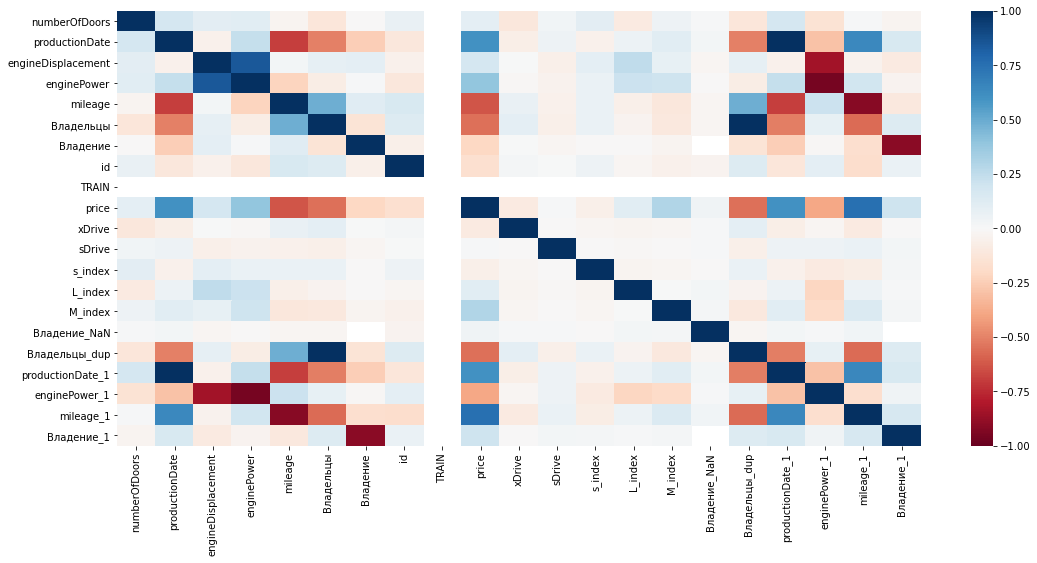

In [31]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [32]:
# Sort absolute correlation values with target variable
corr_table[TARGET].abs().sort_values(ascending=False)

price                 1.000000
mileage_1             0.755004
mileage               0.625444
productionDate_1      0.607175
productionDate        0.602524
Владельцы_dup         0.548962
Владельцы             0.548962
enginePower           0.396430
enginePower_1         0.386685
M_index               0.303680
Владение              0.209443
Владение_1            0.205509
engineDisplacement    0.173924
id                    0.159116
L_index               0.112300
numberOfDoors         0.101063
xDrive                0.091420
s_index               0.060531
Владение_NaN          0.043183
sDrive                0.012363
TRAIN                      NaN
Name: price, dtype: float64

## Significance analysis of quantity and ordinal features
### Analysis of variance (ANOVA)

In [33]:
def anova_analysis(df):
    """Calculate and show significance of quantity and ordinal features based on ANOVA analysis"""
    columns = quantity_cols + ordinal_cols
    df_temp = df[columns + [TARGET]].dropna()
    return pd.Series(f_classif(df_temp[columns], df_temp[TARGET])[0], index=columns)

7.612909521762735

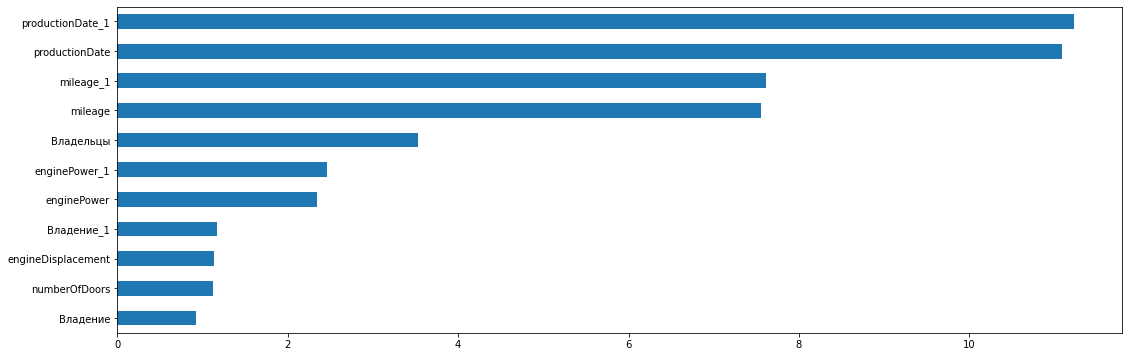

In [34]:
df['mileage'+MINUS_ONE_SUFFIX] = 1 / (df['mileage'] - df['mileage'].min() + 0.1*abs(df['mileage'].median()))

# Do ANOVA analysis
anova_analysis(df.loc[df[TRAIN] == 1]).sort_values().plot(figsize=(18, 6), kind='barh');
anova_analysis(df.loc[df[TRAIN] == 1])['mileage'+MINUS_ONE_SUFFIX]

In [35]:
df['mileage'+MINUS_ONE_SUFFIX] = 1 / (df['mileage'] - df['mileage'].min() + 0.1*abs(df['mileage'].median()))
# Columns to calculate best distributions parameters
columns = ['productionDate', 'enginePower', 'mileage', 'Владение']

# Parameters
MEDIANS = 2
DIVIDERS = 10

# Cycle over columns
param_dict = {}
for column in columns:
    # Cycle over distribution adders
    param_dict[column+MINUS_ONE_SUFFIX] = []
    for adder in range(1, MEDIANS*DIVIDERS + 1):
        # Calc column minus min
        df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min()
            + MEDIANS/DIVIDERS*adder*abs(df[column].median()))
        # Do ANOVA analysis
        anova = anova_analysis(df.loc[df[TRAIN] == 1])[column+MINUS_ONE_SUFFIX]
        param_dict[column+MINUS_ONE_SUFFIX].append(anova)
        
        # Calc column minus max
        df[column+MINUS_ONE_SUFFIX] = 1 / (df[column].max() - df[column]
            + MEDIANS/DIVIDERS*adder*abs(df[column].median()))
        # Do ANOVA analysis
        anova = anova_analysis(df.loc[df[TRAIN] == 1])[column+MINUS_ONE_SUFFIX]
        param_dict[column+MINUS_ONE_SUFFIX].append(anova)
            
pd.DataFrame(param_dict)

,productionDate_1,enginePower_1,mileage_1,Владение_1
0,10.390501,2.809314,8.074667,1.231155
1,11.723237,3.788407,497.783544,0.110115
2,10.725446,2.613316,8.432076,1.236609
3,11.423184,3.006666,138.542516,0.119944
4,10.841528,2.537514,8.503824,1.222576
5,11.314236,2.757717,69.328838,0.134360
6,10.900451,2.493830,8.485091,1.207358
7,11.257904,2.635645,44.208801,0.152396
8,10.936095,2.464834,8.436140,1.193440
9,11.223484,2.563826,32.178895,0.173128


## Significance analysis of categorical features
### Student's t-test

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [36]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categ_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            if column in categ_multi_cols:
                mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[TARGET].notna())
            else:
                mask[column][value] = (df[column] == value) & (df[TARGET].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], TARGET], 
                         df.loc[mask[column][comb[1]], TARGET]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    if len(not_signif_columns):
        print('Statistically significant differences have NOT been found for features:')
        for column in not_signif_columns:
            print(f"'{column}'")
    else:
        print('All categorical features have statistically significant difference with target')
        
    return (top_values, mask)


def boxplot_significance(df, top_values, mask):
    """Show boxplots of features to view significance"""
    # Create figure with [rows x cols] graphs
    rows = len(categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categ_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(TARGET)
        else:
            axs[i].boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(TARGET)

/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Statistically significant differences have NOT been found for features:
'sDrive'


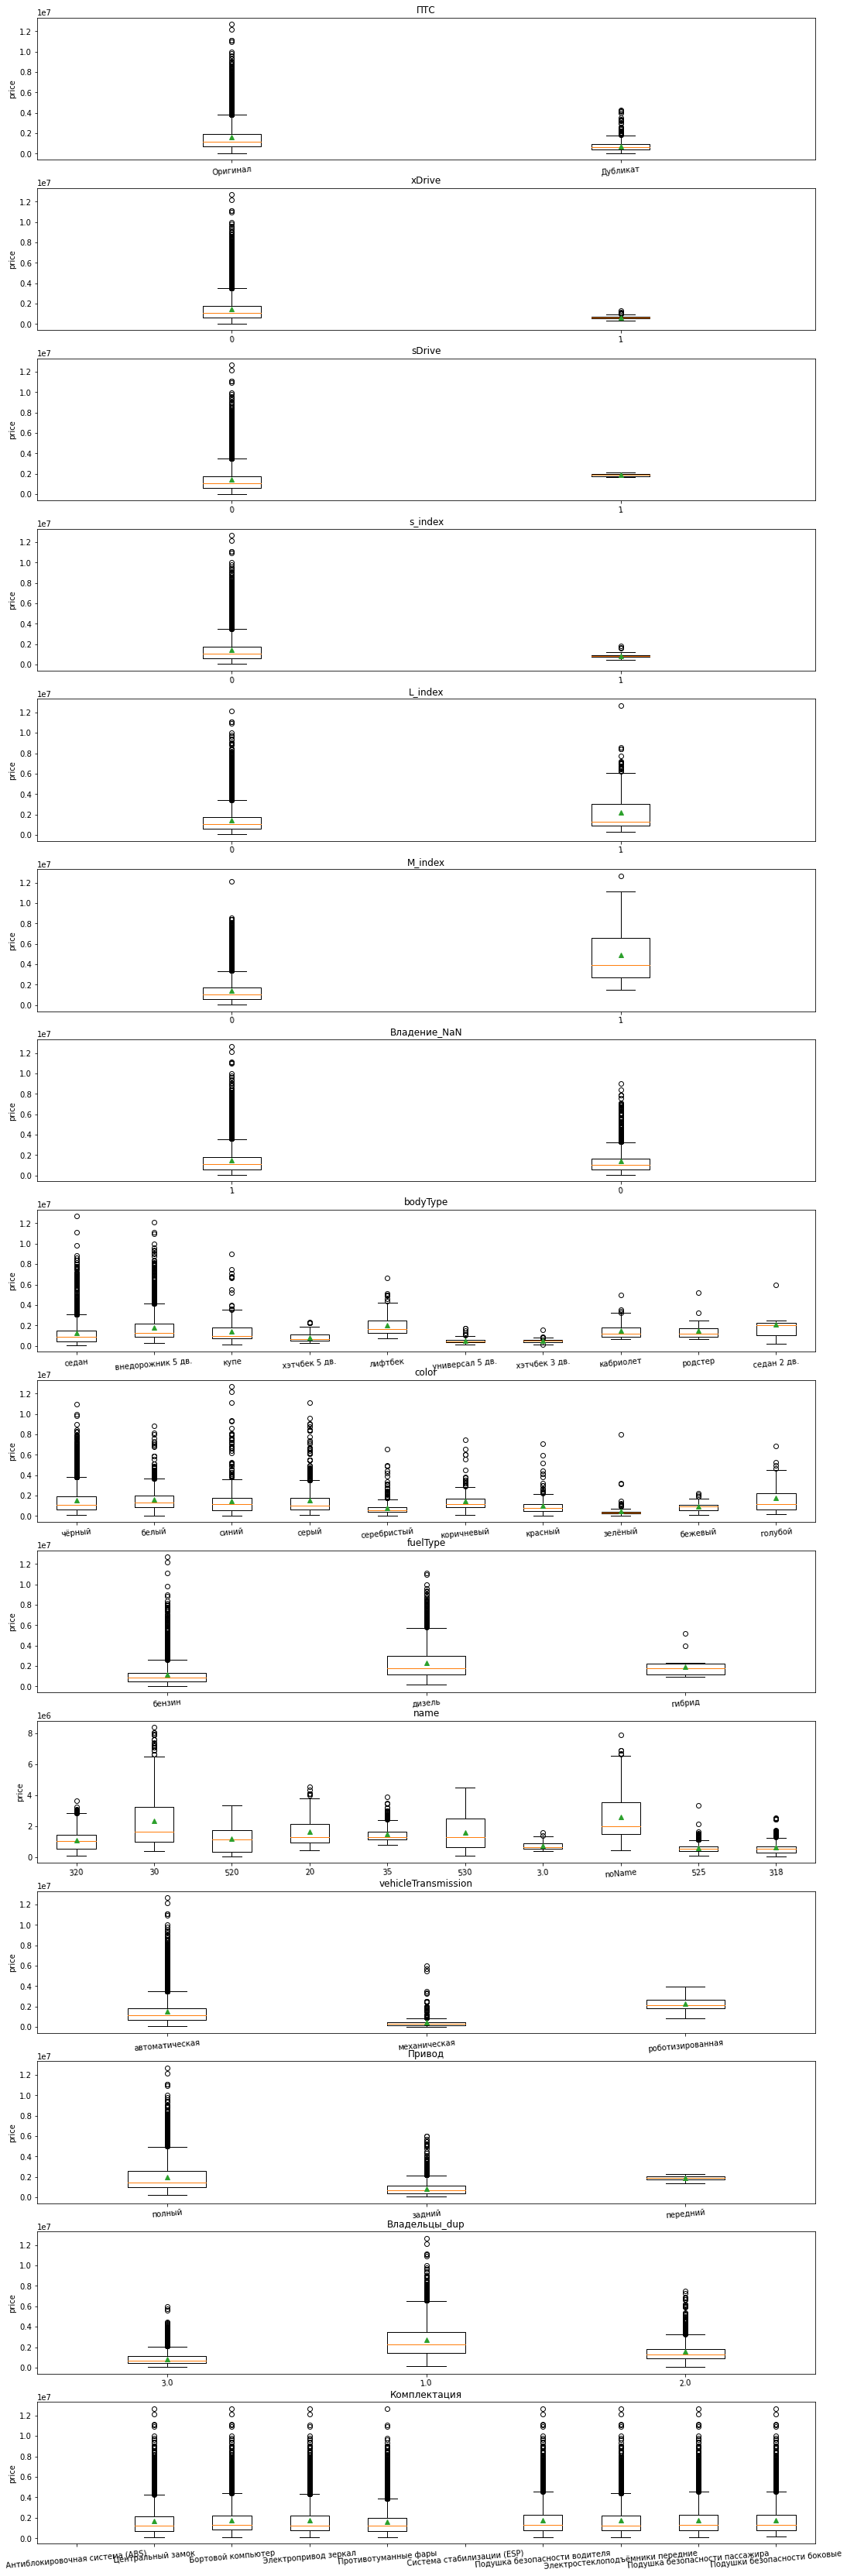

In [37]:
# Do hypothesis testing and show boxplots of significant features
top_values, mask = hypothesis_testing(df.loc[df[TRAIN] == 1])
boxplot_significance(df.loc[df[TRAIN] == 1], top_values, mask)

### Mutual information

In [38]:
def mutual_information_analysis(df):
    """Calculate and show significance of categorical features based on mutual information analysis"""
    columns = categ_bin_cols + categ_many_cols
    df_temp = df[columns + [TARGET]].dropna()
    pd.Series(mutual_info_classif(OrdinalEncoder().fit_transform(df_temp[columns]), df_temp[TARGET], discrete_features=True), index=columns).sort_values().plot(figsize=(18, 6), kind='barh');

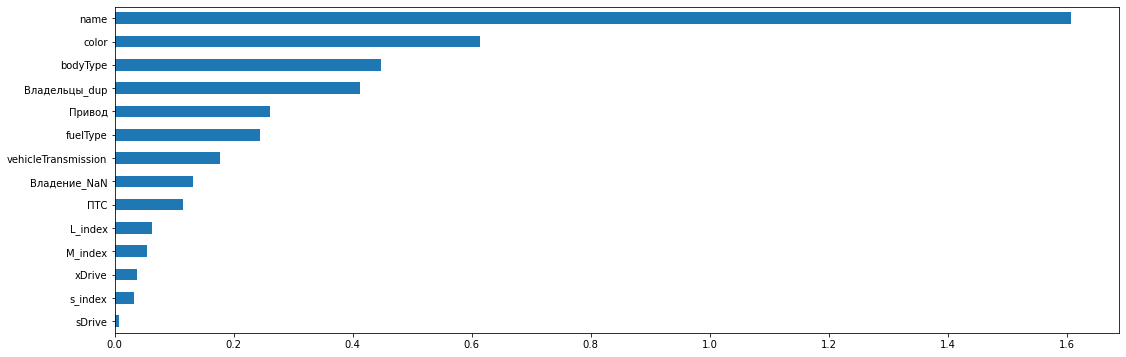

In [39]:
# Do mutual information analysis
mutual_information_analysis(df.loc[df[TRAIN] == 1])

**- Delete proportional and highly correlated features, and also features with week correlation with target variable**

**- Delete features without statistically significant difference**

In [40]:
# Define features to delete
cols = []

# Deleting
df.drop(columns=[col for col in cols if col in df.columns], inplace=True)

# Update feature list
categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
categ_many_cols = [col for col in categ_many_cols if col in df.columns]
categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
quantity_cols = [col for col in quantity_cols if col in df.columns]
quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
ordinal_cols = [col for col in ordinal_cols if col in df.columns]

## Missing values handling

In [41]:
def fill_missing_values(df):
    """Fill missing values (NaNs) for columns"""
    # Drop rows with missing values of target variable
    nan_number = df[TARGET].isna().sum()
    if nan_number:
        df.dropna(subset=[TARGET], inplace=True)
        print(f"{nan_number} rows have been dropped in order to delete missed target values")

    # Drop rows with missing values
    pass
    
    # Fill missing values
    for column in quantity_cols + ordinal_cols + categ_cols:
        # Calculate number of replaced values
        nan_number = df[column].isna().sum()
        
        if nan_number:
            # For individual columns
            if column == 'column_name':
                value = 2
                
            elif column == 'column_2':
                values = df.groupby('categ_column')['column_2'].mean().round()
                df['zzz'] = df['categ_column'].map(values)
                idx = df['column_2'].isna()
                df.loc[idx, 'column_2'] = df.loc[idx, 'zzz']
                df.drop('zzz', axis=1, inplace=True)
                continue

            # For groups of columns
            elif column in quantity_cols:
                value = df[column].mean()
#                 value = df[column].median()
#                 value = df[column].mode()[0]

            elif column in ordinal_cols:
#                 value = df[column].mean()
#                 value = df[column].median()
                value = df[column].mode()[0]

            elif column in categ_bin_cols:
#                 continue
                value = categorical_unique[column].index[0]

            elif column in categ_many_cols:
#                 continue
                value = categorical_unique[column].index[0]

            elif column in categ_multi_cols:
#                 continue
#                 value = categorical_unique[column].index[0]
                values_num = round(df.loc[df[column].notna(), column].apply(lambda x: len(x.split('|'))).mean())
                value = '|'.join(categorical_unique[column].index[:values_num])

            # Replace
            df[column].fillna(value, inplace=True)
            
            # Show number of replaced values in column
            print(f"{str(nan_number).rjust(6)} NaN have been replaced in column '{column}'")

In [42]:
# Fill missing values
fill_missing_values(df)

  5918 NaN have been replaced in column 'Владение'
  5918 NaN have been replaced in column 'Владение_1'


## Polynomial features generation

In [43]:
def generate_polynomials(df, collinear_sens):
    """Generate polynomial features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    df_out = df
    
    # Generate polynomials for quantity_cols
    pf = PolynomialFeatures(2, interaction_only=collinear_sens)
    pf_df = pf.fit_transform(df[quantity_cols])
    pf_cols = pf.get_feature_names(input_features=quantity_cols)
    
    # Find columns of ones
    columns_1 = []
    for column in quantity_cols:
        columns_1.append(column + ' ' + column + MINUS_ONE_SUFFIX)
        columns_1.append(column + MINUS_ONE_SUFFIX + ' ' + column)
    columns_1 = [x for x in columns_1 if x in pf_cols]
    
    # Join dataframe and drop columns of ones
    pf_df = pd.DataFrame(pf_df, columns=pf_cols).drop(columns=quantity_cols+['1']+columns_1)
    df_out = pd.concat([df_out, pf_df], axis=1)    
    
    return df_out

In [44]:
# Generate polynomial features
df = generate_polynomials(df, collinear_sens=False)

## Distributrion normalization

In [45]:
def normalize_distribution(df):
    # Define columns to normalize
    columns = [
#         'age',
        'app_date',
        'bki_request_cnt',
        'decline_app_cnt',
        'income',
#         'score_bki',
    ]
    
    # Normalize distribution
    for column in columns:
        df.loc[df[column].notna(), column] = df.loc[df[column].notna(), column].apply(lambda x: np.log1p(x))
        
    return columns

In [46]:
# Normalize distribution
columns = normalize_distribution(df)

# Show graphs
cols = 4
rows = math.ceil(len(columns)/cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))
for i, column in enumerate(columns):
    idx = i%cols if rows == 1 else (i//cols, i%cols) # Plot indices
    axs[idx].hist(df.loc[df[column].notna(), column])
    axs[idx].set_title(column)

KeyError: 'app_date'

## Dummies generation

In [47]:
def generate_dummies(df, collinear_sens):
    """Dummies generation from categorical features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    df_out = df
    
    # Generate dummies for categ_multi_cols
    for column in categ_multi_cols:
        df_out = pd.concat([df_out, df[column].str.get_dummies()], axis=1)
    df_out.drop(categ_multi_cols, axis=1, inplace=True)

    # Generate dummies for categ_bin_cols and categ_many_cols
    df_out = pd.get_dummies(df, columns=categ_bin_cols+categ_many_cols, drop_first=collinear_sens)

#     # scikit-learn realization
#     drop = 'first' if collinear_sens else None
#     zzz = pd.DataFrame(OneHotEncoder(drop=drop, sparse=False).fit_transform(df[categ_bin_cols + categ_many_cols]))
#     df_out = pd.concat([df, zzz], axis=1).drop(categ_bin_cols + categ_many_cols, axis=1)
    
    return df_out

In [48]:
# Generate dummies
df = generate_dummies(df, collinear_sens=False)

# Model implementation

## Data preparing

In [49]:
# Prepare data
df, sample_submission = collect_data()
format_features(df)
create_new_features(df)
delete_useless_features(df)
dirty_handling(df)
delete_outliers(df, inplace=DROP_AVAL)
fill_missing_values(df)
df = generate_polynomials(df, collinear_sens=False)
normalize_distribution(df)
df = generate_dummies(df, collinear_sens=False)

df_temp = df.copy()
df_temp

   273 outliers are in column 'engineDisplacement'
   455 outliers are in column 'enginePower'
    46 outliers are in column 'enginePower_1'
   258 outliers are in column 'mileage'
   617 outliers are in column 'numberOfDoors'
   370 outliers are in column 'productionDate'
   370 outliers are in column 'productionDate_1'
    95 outliers are in column 'Владение'
  5918 NaN have been replaced in column 'Владение'
  5918 NaN have been replaced in column 'Владение_1'


KeyError: 'app_date'

In [50]:
df = df_temp.copy()

NameError: name 'df_temp' is not defined

## Data splitting & Data scaling

In [51]:
def split_dataframe(data, test_size, stratify=True, normalize=True):
    """Split dataframe to: X, X_train, X_test, y, y_train, y_test"""
    # Split data: Х - features, у - target variable
    y = data.loc[data[TRAIN] == 1, TARGET].values
    X = data.loc[data[TRAIN] == 1].drop([TRAIN, TARGET], axis=1)

    # Split data on train and test parts
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=strat, shuffle=True, random_state=RANDOM_SEED)

    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    return (X, X_train, X_test, y, y_train, y_test)

In [52]:
# Data splitting
X, X_train, X_test, y, y_train, y_test = split_dataframe(df, test_size=0.2)
print('Shapes:', X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Features tuning

In [53]:
def train_test_vs_sample_value(model, data, cv):
    """Calculate train and test scores versus sample value.
    
    It is in order to detect high bias or high variance.
    It also helps to find optimum sample value to fit model for tuning.
    """
    # Input variable
    PART_FACTOR = 5
    
    # Separate train data
    df = data.loc[data[TRAIN] == 1].drop([TRAIN], axis=1)
    y = df[TARGET].values
    
    # Cycle over stratified folds
    score = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    for i, (train_index, test_index) in enumerate(skf.split(df.values, y)):
        # Split on train and test
        data_train, data_test = df.iloc[train_index, :], df.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        data_train_0 = data_train.loc[data_train[TARGET] == 0]
        data_train_1 = data_train.loc[data_train[TARGET] == 1]
        X_test = data_test.drop([TARGET], axis=1)
        X_test = StandardScaler().fit_transform(X_test)

        # Define start, stop, step
        START = data_train_1.shape[0] // PART_FACTOR
        STOP = data_train_0.shape[0]
        STEP = START

        # Cycle over train size
        sample_val = []
        score_train = []
        score_test = []
        for train_size in range(START, STOP, STEP):
            # Split and standardize data
            data_train_iter = data_train_1.append(data_train_0.iloc[:train_size, :], ignore_index=True)
            X_train_iter = data_train_iter.drop([TARGET], axis=1)
            X_train_iter = StandardScaler().fit_transform(X_train_iter)
            y_train_iter = data_train_iter[TARGET].values

            # Learn model
            model.fit(X_train_iter, y_train_iter)

            # Test model
            sample_val.append(X_train_iter.shape[0])
            score_train.append(roc_auc_score(y_train_iter, model.predict_proba(X_train_iter)[:,1]))
            score_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
            
            # Print an intermediate result
            print(f'Completed: fold_iteration = {i}; train_size = {X_train_iter.shape[0]}')
        
        # Append fold result
        score.append({'sample_value': sample_val, 'ROC_AUC_train': score_train, 'ROC_AUC_test': score_test})

    # Average result
    length = len(score[0]['sample_value'])
    sample_val = [0]*length
    score_train = [0]*length
    score_test = [0]*length
    for scr in score:
        for i in range(length):
            sample_val[i] += scr['sample_value'][i]
            score_train[i] += scr['ROC_AUC_train'][i]
            score_test[i] += scr['ROC_AUC_test'][i]
    for i in range(length):
        sample_val[i] /= cv
        score_train[i] /= cv
        score_test[i] /= cv
    
    return pd.DataFrame.from_dict({'sample_value': sample_val, 'ROC_AUC_train': score_train, 'ROC_AUC_test': score_test})


def find_usefull_useless_feature(model, data, cv, usefull_cols=None):
    """Find the most usefull or useless feature.
    
    Find the most usefull feature to add if 'usefull_cols' is a list.
    Find the most useless feature to drop if 'usefull_cols' is None.
    """
    # Input variables
    GREATER_SCORE_IS_BETTER = True
    
    # Separate train data
    X = data.loc[data[TRAIN] == 1].drop([TARGET, TRAIN], axis=1)
    y = data.loc[data[TRAIN] == 1, TARGET].values
    
    # Cycle over stratified folds
    f_train_score = defaultdict(int)
    f_test_score = defaultdict(int)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    for i, (test_index, train_index) in enumerate(skf.split(X.values, y)): # inverse order of train and test indices
        # Split on train and test
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        # Standardize train and test parts
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        
        # Determine columns list
        if usefull_cols is not None:
            columns = [col for col in X_train.columns if col not in usefull_cols]
        else:
            columns = X_train.columns # [0:110]

        # Cycle over features
        for j, column in enumerate(columns):
            # Define train and test data
            if usefull_cols is not None:
                cols = usefull_cols + [column]
                X_train_temp = X_train[cols]
                X_test_temp = X_test[cols]
            else:
                X_train_temp = X_train.drop(column, axis=1)
                X_test_temp = X_test.drop(column, axis=1)

            # Create and learn model
            model.fit(X_train_temp, y_train)

            # Test model and update dicts
            f_train_score[column] += roc_auc_score(y_train, model.predict_proba(X_train_temp)[:,1])
            f_test_score[column] += roc_auc_score(y_test, model.predict_proba(X_test_temp)[:,1])
            
            # Print an intermediate result
            print(f'fold_iteration {i}, feature_iteration {j} completed')
            if GREATER_SCORE_IS_BETTER:
                feature = max(f_test_score, key=f_test_score.get)
            else:
                feature = min(f_test_score, key=f_test_score.get)
            print(feature, f_test_score[feature])

    # Average result
    for column in f_train_score.keys():
        f_train_score[column] /= cv
        f_test_score[column] /= cv
    
    # Form result DataFrame
    result = pd.DataFrame.from_dict([f_train_score, f_test_score]).transpose().reset_index()
    result.columns = ['feature', 'score_train', 'score_test']
    
    return result.sort_values('score_test', ascending=not GREATER_SCORE_IS_BETTER, ignore_index=True)


def find_several_usefull_useless_features(model, data, features_num, cv, usefull_cols=None):
    """Find several usefull of useless features at a time.
    
    Find the most usefull features to add if 'usefull_cols' is a list.
    Find the most useless features to drop if 'usefull_cols' is None.
    """
    # Find exact features_num
    if usefull_cols is not None:
        features_num = min(features_num, data.shape[1] - len(usefull_cols) - 2) # minus TRAIN and TARGET cols
    else:
        features_num = min(features_num, data.shape[1] - 2) # minus TRAIN and TARGET cols

    # Find features
    useless_cols = []
    features_score = pd.DataFrame(columns=['feature', 'score_train', 'score_test'])
    for i in range(features_num):
        if usefull_cols is not None:
            # Find usefull feature and append it
            df_score = find_usefull_useless_feature(model, data=data, cv=cv, usefull_cols=usefull_cols)
            usefull_cols.append(df_score.iloc[0, 0])
        else:
            # Find useless feature and drop it
            df_score = find_usefull_useless_feature(model, data=data.drop(useless_cols, axis=1), cv=cv)
            useless_cols.append(df_score.iloc[0, 0])

        # Print an intermediate result
        features_score = features_score.append(df_score.iloc[0], ignore_index=True)
        features_score.to_csv('train_test_score_vs_feature_number_new.csv', index=False)
        print('Feature number =', i)
        print(features_score)
        
    return features_score

In [54]:
# usefull_cols = [
#        'score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
#        'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
#        'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_N',
#        'score_bki decline_app_cnt_1', 'region_rating_7',
#        'work_address_dup', 'region_rating_dup_dup bki_request_cnt_1',
#        'first_time_1', 'good_work_0', 'age score_bki',
#        'region_rating_dup_dup age_1', 'client_id_1 score_bki_1',
#        'foreign_passport_N', 'sna_2', 'age region_rating_dup_dup_1',
#        'age_1 decline_app_cnt_1', 'decline_app_cnt income', 'app_date',
#        'decline_app_cnt',
# ]

# Compute train and test scores versus sample value to define whether the model has high bias or high variance
# and find optimum train-test sample proportion to tune features
# model = LogisticRegression(class_weight={0:1,1:5}, C=40, max_iter=1000, n_jobs=-1, verbose=1)
# %time score = train_test_vs_sample_value(model, df[usefull_cols + [TARGET, TRAIN]], cv=10)

# Update sample value score dataframe
score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_sample_value.csv')
score.to_csv('train_test_score_vs_sample_value.csv', index=False)

# Plot train and test scores versus sample value
score.plot(x='sample_value', figsize=(18, 8), grid=True, title='Train and test scores vs train sample value')
print(score.nlargest(1, 'ROC_AUC_test'))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/kernel341ca18171/train_test_score_vs_sample_value.csv'

The sample value of 25000 for train set is a good choice to find usefull features

In [55]:
# Already found usefull features
usefull_cols = [
# baseline
#     'client_id',
#     'age','app_date','bki_request_cnt',
#     'decline_app_cnt','education_dup','first_time_dup',
#     'home_address_dup','income','region_rating_dup',
#     'score_bki','sna_dup','work_address_dup',
    
# iteration 1
#     'score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
#     'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
#     'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_N',
#     'score_bki decline_app_cnt_1', 'region_rating_7',
#     'work_address_dup', 'region_rating_dup_dup bki_request_cnt_1',
#     'first_time_1', 'good_work_0', 'age score_bki',
#     'region_rating_dup_dup age_1', 'client_id_1 score_bki_1',
#     'foreign_passport_N', 'sna_2', 'age region_rating_dup_dup_1',
#     'age_1 decline_app_cnt_1', 'decline_app_cnt income', 'app_date',
#     'decline_app_cnt', 'sna_3', 'region_rating_5', 'bki_request_cnt^2',
#     'sna_1', 'sex_M', 'foreign_passport_Y', 'car_type_Y',
#     'good_work_1', 'sna_4', 'client_id score_bki',
#     'client_id bki_request_cnt_1', 'region_rating_dup_dup app_date_1',
#     'client_id income_1', 'region_rating_dup_dup client_id_1',
#     'app_date bki_request_cnt_1', 'region_rating_dup_dup client_id_1',
#     'app_date bki_request_cnt_1', 'income^2', 'app_date income_1',
#     'region_rating_6', 'client_id decline_app_cnt_1',
#     'app_date decline_app_cnt_1', 'app_date_1^2',
#     'app_date_1 client_id_1', 'client_id_1^2',
#     'app_date_1 score_bki_1', 'bki_request_cnt_1 client_id_1',
#     'app_date_1 bki_request_cnt_1', 'age_1 bki_request_cnt_1',
#     'bki_request_cnt region_rating_dup_dup', 'score_bki age_1',
#     'bki_request_cnt score_bki', 'bki_request_cnt_1 income_1',
#     'score_bki income_1', 'region_rating_dup_dup income_1', 'income',
#     'income_1 score_bki_1', 'income bki_request_cnt_1',
#     'age region_rating_dup_dup', 'region_rating_dup_dup_1 client_id_1',
#     'client_id^2', 'income_1^2', 'client_id_1',
    
# iteration 2
       'score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
       'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
       'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_Y',
       'score_bki decline_app_cnt_1', 'region_rating_7', 'work_address_1',
       'region_rating_dup_dup bki_request_cnt_1', 'first_time_1',
       'good_work_1', 'client_id_1', 'age_1 income_1', 'region_rating_5',
       'region_rating_dup_dup_1 score_bki_1', 'sna_3',
       'score_bki income_1', 'region_rating_dup_dup age_1', 'client_id^2',
       'client_id', 'app_date client_id', 'foreign_passport_N', 'sna_1',
       'work_address_3', 'decline_app_cnt income_1',
       'decline_app_cnt score_bki', 'income region_rating_dup_dup_1',
       'income region_rating_dup_dup', 'app_date region_rating_dup_dup_1',
       'work_address_2', 'work_address_dup', 'car_type_N', 'sna_4',
       'good_work_0', 'sex_M', 'education_PGR', 'foreign_passport_Y',
       'education_NaN_0', 'sna_2', 'education_NaN_1', 'region_rating_6',
       'app_date^2', 'region_rating_dup_dup decline_app_cnt_1', 'age_1^2',
       'age_1', 'age^2', 'age', 'region_rating_dup_dup income_1',
       'income', 'income_1 score_bki_1', 'income^2',
       'app_date score_bki_1',
]

# Compute next usefull features
# cv = round(df.shape[0] / 25000)
# cv = cv if cv >= 2 else 2
# model = LogisticRegression(class_weight={0:1,1:5}, C=40, max_iter=1000, n_jobs=-1, verbose=1)
# %time find_several_usefull_useless_features(model, df, features_num=50, cv=cv, usefull_cols=usefull_cols)

# Update features score dataframe
# First time
# features_score = pd.read_csv(PATH_WORKING+'train_test_score_vs_feature_number_new.csv')
# features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)
# Next times
# features_score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_feature_number.csv')
# features_score_new = pd.read_csv('/kaggle/input/temporary0/train_test_score_vs_feature_number_new.csv')
# features_score = features_score.append(features_score_new, ignore_index=True)
# features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)
# Done
features_score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_feature_number.csv')
features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)

# Plot train and test scores versus number of features
features_score['features number'] = features_score.index + 1
features_score.plot(x='features number', figsize=(18, 8), grid=True,
    title='Train and test scores vs number of features', ylim=(0.735, 0.738));
print(features_score.nlargest(1, 'score_test'))
features_score['feature'].values

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/kernel341ca18171/train_test_score_vs_feature_number.csv'

## Hyperparameters tuning

In [56]:
# Show available metrics to optimize hyperparameters
# sorted(SCORERS.keys())

In [57]:
def tune_class_balance(X, y, weights, C=1, cv=5):
    """Find optimum class weights"""
    # Define cross validation
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
    
    # Define model
    model = LogisticRegression(C=C, max_iter=1000, verbose=1, n_jobs=-1)
    
    # Define and fit grid search
    model = GridSearchCV(estimator=model, param_grid=dict(class_weight=weights), scoring=METRIC, cv=cv, n_jobs=-1, verbose=1)
    model.fit(X, y)
    
    # Print the best configuration
    print("Best score: %f using %s" % (model.best_score_, model.best_params_))


def tune_regularization(X, y, Cs, weight={0:1,1:1}, cv=5):
    """Find optimum regularization parameter C"""
    # Define cross validation
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
    
    # Define and fit model
    model = LogisticRegressionCV(Cs=Cs, cv=cv, class_weight=weight, scoring=METRIC, max_iter=1000, n_jobs=-1, verbose=1)
    model.fit(X, y)

    print('C_ =', model.C_)
    print('Cs_ =', model.Cs_)
    print('scores_ =', model.scores_)

In [58]:
# Show balanced weights
compute_class_weight('balanced', classes=np.unique(y), y=y)

# Find the best class weights
weights = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}]
weights = [{0:1,1:5.1}, {0:1,1:5.4}, {0:1,1:5.7}, {0:1,1:6.0}, {0:1,1:6.3}, {0:1,1:6.6}, {0:1,1:6.9}]
weights = [{0:1,1:5.8}, {0:1,1:5.9}, {0:1,1:6.0}, {0:1,1:6.1}, {0:1,1:6.2}]
# tune_class_balance(X[usefull_cols], y, weights=weights, C=1, cv=2)

NameError: name 'y' is not defined

In [59]:
# Find the best regularization parameter C
Cs = [1, 10, 100, 1000]
Cs = [1, 5, 10, 50, 100]
Cs = [20, 30, 40, 50, 60, 70, 80, 90]
Cs = [71, 74, 77, 80, 83, 86, 89]
Cs = [72, 73, 74, 75, 76]
# tune_regularization(X[usefull_cols], y, weight={0:1,1:6.0}, Cs=Cs, cv=10)

## Model testing

In [60]:
# Define cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)

# Define model
model = LogisticRegression(class_weight={0:1,1:6}, C=74, max_iter=1000, n_jobs=-1, verbose=1)

# Evaluate model
score = cross_val_score(model, X[usefull_cols], y, scoring=METRIC, cv=cv, n_jobs=-1, verbose=1)
print('Shapes:', X[usefull_cols].shape, y.shape)
print('Mean ROC AUC score =', statistics.mean(score))


# Fit model on test set
model.fit(X_train[usefull_cols], y_train)
# View important model characteristics
print('classes_ =', model.classes_)
print('coef_ =', model.coef_)
print('intercept_ =', model.intercept_)
# Test model
score = roc_auc_score(y_test, model.predict_proba(X_test[usefull_cols])[:,1])
# Plot ROC AUC curve
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test[usefull_cols])[:,1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

NameError: name 'X' is not defined

# Submission
**Learn model on 100% of train data**

In [61]:
# Create and learn model
model = LogisticRegression(class_weight={0:1,1:6}, C=74, max_iter=1000, n_jobs=-1, verbose=1)
model.fit(X[usefull_cols], y)

# Splitting and scaling data to predict
X_predict = df.loc[df[TRAIN] == 0, usefull_cols]
X_predict = StandardScaler().fit_transform(X_predict)
model.predict_proba(X_predict)[:,1]

# Predict target variable
predict_submission = model.predict_proba(X_predict)[:,1]

# Postprocess
pass

NameError: name 'X' is not defined

**Write result to submission file**

In [62]:
sample_submission = pd.DataFrame()
sample_submission[IDENT] = df.loc[df[TRAIN] == 0, IDENT].values
sample_submission[TARGET] = predict_submission
sample_submission.reset_index(drop=True, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission

NameError: name 'predict_submission' is not defined

# What's next?
Или, что делать, чтобы улучшить результат:

- Try KNeighborsClassifier
- Feature Engineering (tune every feature, -1 degree features, polynomial features)
- Tune hyperparameters
- Working with unbalanced sample (over & under sampling; class weights)

In [63]:
def baseline():
    def split_dataframe_(df, test_size, normalize):
        y = df[TARGET].values
        X = df.drop([TARGET], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)

        if normalize:
            scaler = StandardScaler()
            X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
            X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        return (X, X_train, X_test, y, y_train, y_test)
    
    df_join_ = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')

    df_join_['education_NaN'] = df_join_['education'].isna().astype('uint8')
    df_join_['education'].fillna('SCH', inplace=True)
    df_join_.drop('client_id', axis=1, inplace=True)

    categ_bin_cols_ = [
        'sex',
        'car',
        'car_type',
        'good_work',
        'foreign_passport',
        'education_NaN',
    ]
    categ_many_cols_ = [
        'home_address',
        'work_address',
        'education',
    ]
    quantity_cols_ = [
        'age',
        'income',
        'client_id',
        'decline_app_cnt',
        'bki_request_cnt',
    ]
    
    df_join_['age'] = df_join_['age'].apply(lambda x: np.log1p(x))
    df_join_['income'] = df_join_['income'].apply(lambda x: np.log1p(x))
    df_join_['decline_app_cnt'] = df_join_['decline_app_cnt'].apply(lambda x: np.log1p(x))
    df_join_['bki_request_cnt'] = df_join_['bki_request_cnt'].apply(lambda x: np.log1p(x))
    
    df_join_ = pd.get_dummies(df_join_, columns=categ_bin_cols_+categ_many_cols_, drop_first=False)
    
    # Split data
    X, X_train, X_test, y, y_train, y_test = split_dataframe_(df_join_, test_size=0.2, normalize=True)
    # Check data dimensions
    print('Shapes:', X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)
    # Create and learn model
    model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
    # View important model characteristics
    print('classes_ =', model.classes_)
    print('coef_ =', model.coef_)
    print('intercept_ =', model.intercept_)
    # Test model
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('ROC AUC =', score)
    
# baseline()